*Antonio Coín Castro*     


# Bayesian Functional Logistic Regression

In [40]:
# -- Libraries

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import arviz as az
import numpy as np
import pandas as pd
from IPython.display import display
import logging
import skfda
from skfda.preprocessing.dim_reduction.variable_selection import (
    RKHSVariableSelection as RKVS,
    RecursiveMaximaHunting as RMH,
    MinimumRedundancyMaximumRelevance as mRMR,
)
import os
from _lda import LDA
from _fpls import FPLS, APLS, FPLSBasis
from _fpca_basis import FPCABasis
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import FDataBasis, Fourier, BSpline
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.validation import (
    SmoothingParameterSearch,
    LinearSmootherGeneralizedCVScorer,
    akaike_information_criterion
)
from skfda.preprocessing.smoothing.kernel_smoothers import (
    NadarayaWatsonSmoother as NW
)
from skfda.ml.classification import (
    MaximumDepthClassifier, KNeighborsClassifier,
    NearestCentroid,
)
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
import warnings
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
import sys
import pickle
import scipy
from multiprocessing import Pool
import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [41]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We consider the binary $\{0,1\}$-model

$$
\mathbb P(Y=1\mid X=x) = \frac{1}{1 + \exp\{-\alpha_0-\Psi^{-1}_{x}(\alpha)\}},
$$

i.e., each $Y_i$ can be seen as a Bernoulli random variable $\mathcal B(p(x_i))$ with

$$
p(x_i)\equiv p_i=\mathbb P(Y_i=1\mid X_i=x_i) = \frac{1}{1 + \exp\left\{-\alpha_0-\displaystyle\sum_{j=1}^p \beta_jx_i(\tau_j)\right\}}.
$$

Note that $\mathbb E[Y_i]=p_i$ and $\operatorname{Var}(Y_i)=p_i(1-p_i)$.

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right).
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log \sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \sum_{i=1}^n \left[ \left(\alpha_0 + \Psi^{-1}_{x_i}(\alpha)\right)y_i - \log\left(1 + \exp\left\{\alpha_0 + \Psi_{x_i}^{-1}(\alpha)\right\}\right)\right] +
\frac{1}{2}\log |G_\tau| - p\log \sigma -\frac{1}{2g\sigma^2} (\beta - b_0)'G_\tau(\beta - b_0).  
$$

The metrics considered for model evaluation will be:

- Accuracy.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, and a value of $\alpha_0=-0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 + 5X_i(0.1) - 10X_i(0.8)\right\}}\right)
$$

or

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 -\int_0^1 \beta(t)X_i(t)\, dt\right\}}\right),
$$

where $\beta(t) \in L^2[0, 1]$.

Another possibility is to generate a dataset from two different Gaussian processes, and label them according to the (known) distribution of $X^{(j)}$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [42]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2', 'RKHS' or 'MIXTURE'
REAL_DATA = "Medflies"
NOISE = 0.10

INITIAL_SMOOTHING = "NW"  # 'NW' or 'Basis'
N_BASIS = 16
STANDARDIZE_PREDICTORS = False

kernel_fn = utils.fractional_brownian_kernel
kernel_fn2 = utils.squared_exponential_kernel
beta_coef = utils.cholaquidis_scenario3

basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning:One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan -0.001 -0.001 -0.001
 -0.001 -0.001 -0.    -0.    -0.001 -0.001 -0.001 -0.002 -0.003 -0.007
 -0.013 -0.026 -0.048 -0.071 -0.088 -0.098 -0.103 -0.105 -0.106 -0.107
 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107
 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107 -0.107]


Smoother: NadarayaWatsonSmoother
Smoothing parameter: 0.013


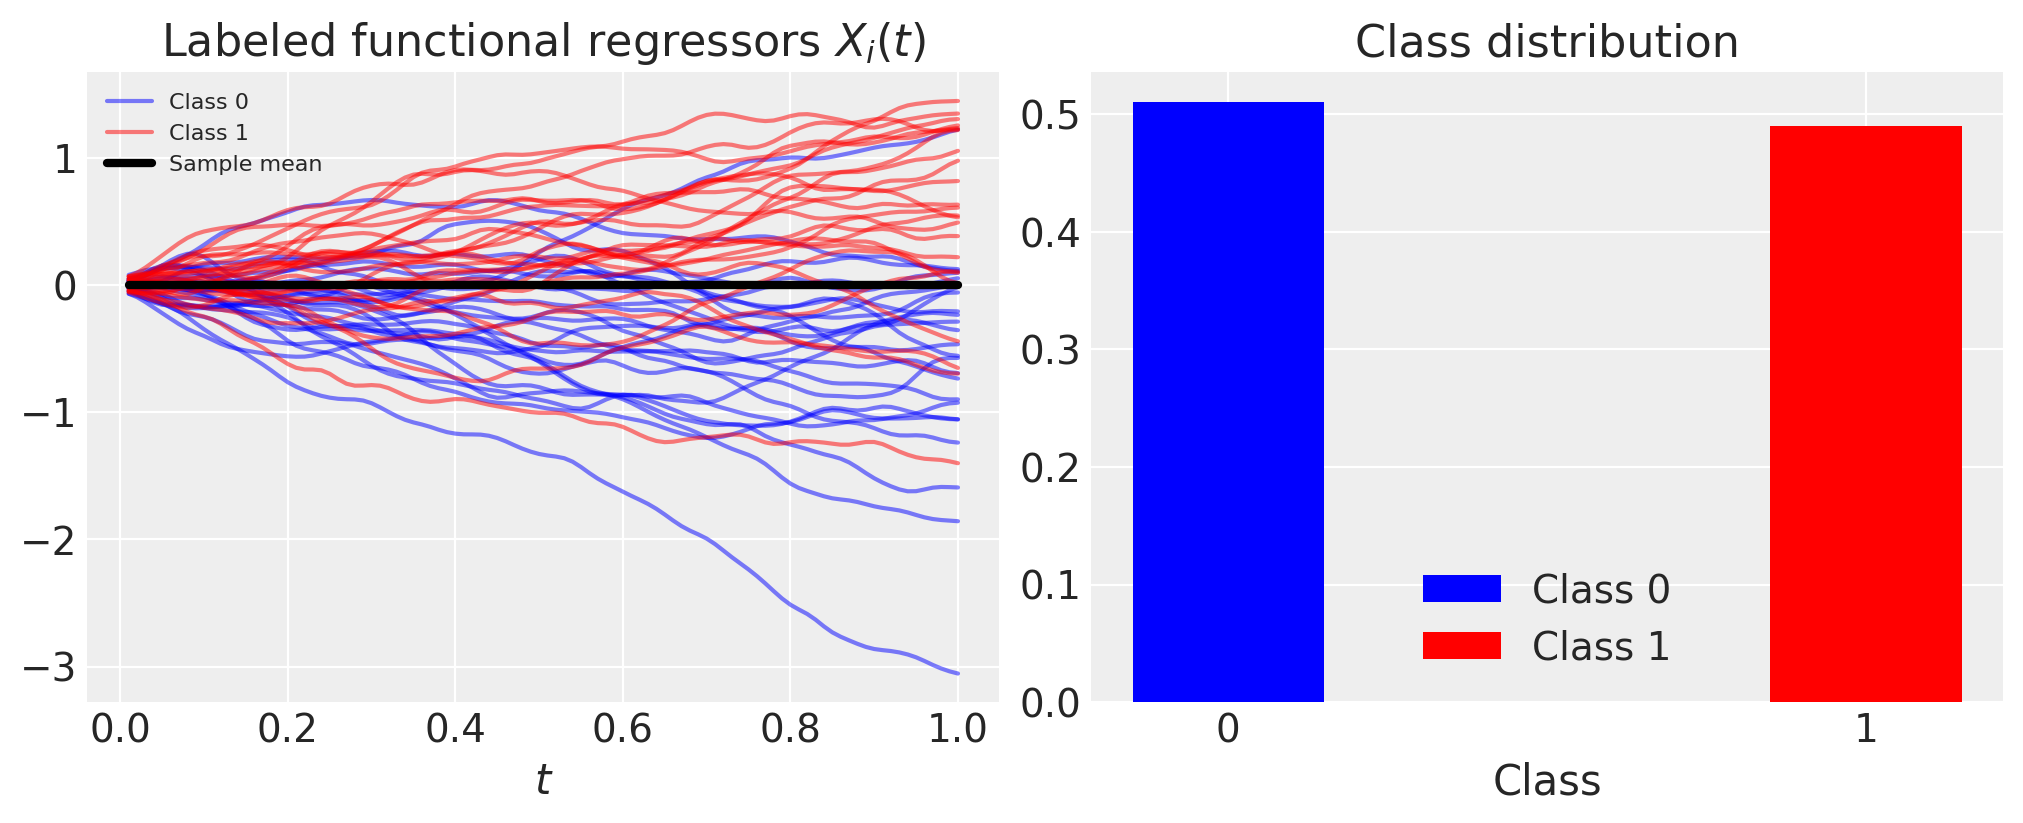

In [43]:
# -- Dataset generation

if SYNTHETIC_DATA:
    n_train, n_test = 100, 50
    N = 100
    grid = np.linspace(1./N, 1., N)

    mean_vector = None
    mean_vector2 = np.ones(N)

    beta_true = np.array([-5., 10.])
    tau_true = np.array([0.1, 0.8])
    alpha0_true = -0.5

    if MODEL_GEN == "MIXTURE":
        x, y = utils.generate_classification_dataset(
            grid, kernel_fn, kernel_fn2,
            n_train + n_test, rng,
            mean_vector, mean_vector2)
    else:
        if MODEL_GEN == "L2":
            x, y_lin = utils.generate_gp_l2_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_coef,
                alpha0_true, 0.0, rng=rng
            )
        elif MODEL_GEN == "RKHS":
            x, y_lin = utils.generate_gp_rkhs_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_true, tau_true,
                alpha0_true, 0.0, rng=rng
            )
        else:
            raise ValueError("Invalid model generation strategy.")

        # Transform linear response for logistic model
        y = utils.transform_linear_response(y_lin, noise=NOISE, rng=rng)

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, stratify=y,
        random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:
    if REAL_DATA == "Medflies":
        x, y = skfda.datasets.fetch_medflies(return_X_y=True)
    elif REAL_DATA == "Growth":
        x, y = skfda.datasets.fetch_growth(return_X_y=True)
    else:
        raise ValueError("REAL_DATA must be 'Medflies' or 'Growth'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.8, stratify=y, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = np.linspace(1./N, 1., N)  # TODO: use (normalized) real grid
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    best_smoother = SmoothingParameterSearch(
        smoother,
        smoothing_params,
        scoring=LinearSmootherGeneralizedCVScorer(
            akaike_information_criterion),
        n_jobs=-1,
    )

    with utils.IgnoreWarnings():
        best_smoother.fit(X_fd)

    X_fd = best_smoother.transform(X_fd)
    X_test_fd = best_smoother.transform(X_test_fd)
    print(f"Smoother: {best_smoother.best_estimator_.__class__.__name__}")
    print(
        f"Smoothing parameter: {best_smoother.best_params_['smoothing_parameter']:.3f}")

if STANDARDIZE_PREDICTORS:
    X_sd = np.sqrt(X_fd.var())
else:
    X_sd = 1.0

# Standardize data
X_m = X_fd.mean(axis=0)
X_fd = (X_fd - X_m)/X_sd
X = X_fd.data_matrix.reshape(-1, N)
X_test_fd = (X_test_fd - X_m)/X_sd
X_test = X_test_fd.data_matrix.reshape(-1, N)

if SYNTHETIC_DATA:
    n_samples = n_train//2
elif REAL_DATA == "Medflies":
    n_samples = n_train//5
else:
    n_samples = n_train

utils.plot_dataset_classification(X, Y, figsize=(10, 4), n_samples=n_samples)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [44]:
# -- Model hyperparameters

p_hat = 3
g = 5
eta = 0.1

TRANSFORM_TAU = False
FIT_SK = True

In [45]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if TRANSFORM_TAU:
    theta_names_ttr = ["β", "logit τ", "α0", "log σ"]
else:
    theta_names_ttr = ["β", "τ", "α0", "log σ"]
theta_names_aux = ["α0 and log σ"]

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = []
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

# Names of results columns
results_columns = ["Estimator", "Features", "Accuracy"]

In [46]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = utils.Logit()
else:
    tau_ttr = utils.Identity()

# Parameter space
theta_space = utils.ThetaSpace(
    p_hat, grid, theta_names, theta_names_ttr, theta_labels, tau_ttr=tau_ttr)

# Statistics for posterior predictive checks
statistics = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)]

# Point estimates for posterior distribution
point_estimates = ["mode", "mean", "median"]

## Sklearn model comparison

In [56]:
# -- Custom CV and transformers

def cv_sk(classifiers, folds, X, Y, X_test, Y_test, verbose=False):
    df_metrics_sk = pd.DataFrame(columns=results_columns)

    for i, (name, pipe, params) in enumerate(classifiers):
        if verbose:
            print(f"Fitting {name}...")
        clf_cv = GridSearchCV(pipe, params, scoring="accuracy",
                              n_jobs=N_CORES, cv=folds)

        with utils.IgnoreWarnings():
            clf_cv.fit(X, Y)

        Y_hat_sk = clf_cv.predict(X_test)
        metrics_sk = utils.classification_metrics(Y_test, Y_hat_sk)

        if name == "sk_fknn":
            n_features = f"K={clf_cv.best_params_['clf__n_neighbors']}"
        elif name == "sk_mdc" or name == "sk_fnc":
            n_features = X.data_matrix.shape[1]
        elif name == "sk_flr":
            n_features = clf_cv.best_estimator_["clf"].p
        elif "pls1" in name:
            n_features = \
                clf_cv.best_estimator_["clf"].base_regressor.n_components
        elif "svm" in name:
            n_features = clf_cv.best_estimator_["clf"].n_features_in_
        else:
            if isinstance(clf_cv.best_estimator_["clf"].coef_[0], FDataBasis):
                coef = clf_cv.best_estimator_["clf"].coef_[0].coefficients[0]
            elif "sk_logistic" in name:
                coef = clf_cv.best_estimator_["clf"].coef_[0]
            else:
                coef = clf_cv.best_estimator_["clf"].coef_

            n_features = sum(~np.isclose(coef, 0))

        df_metrics_sk.loc[i] = [
            name,
            n_features,
            metrics_sk["acc"]]

        df_metrics_sk.sort_values(
            results_columns[-1], inplace=True, ascending=False)

    return df_metrics_sk, clf_cv


def bayesian_var_sel(idata, theta_space, names,
                     X, Y, X_test, Y_test, folds,
                     prefix, point_est='mode',
                     verbose=False):
    grid = theta_space.grid
    p_hat = theta_space.p
    tau_hat = utils.point_estimate(
        idata, point_est, names)[p_hat:2*p_hat]
    idx_hat = np.abs(grid - tau_hat[:, np.newaxis]).argmin(1)

    classifiers_var_sel = []
    Cs = np.logspace(-4, 4, 20)
    params_clf = {"clf__C": Cs}
    params_svm = {"clf__gamma": ['auto', 'scale']}

    # Emcee+LR
    classifiers_var_sel.append((f"{prefix}_{point_est}+sk_logistic",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", LogisticRegression(random_state=SEED))]),
                               params_clf
                                ))

    # Emcee+SVM Linear
    classifiers_var_sel.append((f"{prefix}_{point_est}+sk_svm_lin",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", LinearSVC(random_state=SEED))]),
                               params_clf
                                ))

    # Emcee+SVM RBF
    classifiers_var_sel.append((f"{prefix}_{point_est}+sk_svm_rbf",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", SVC(kernel='rbf'))]),
                               {**params_svm, **params_clf}
                                ))

    df_metrics_var_sel, _ = cv_sk(classifiers_var_sel, folds,
                                  X_fd, Y, X_test_fd, Y_test, verbose)

    return df_metrics_var_sel


class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y=None):
        N = X.shape[1]
        self.idx_ = np.linspace(0, N - 1, self.p).astype(int)
        return self

    def transform(self, X, y=None):
        return X[:, self.idx_]


class DataMatrix(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.N = len(X.grid_points[0])
        return self

    def transform(self, X, y=None):
        return X.data_matrix.reshape(-1, self.N)


class Basis(BaseEstimator, TransformerMixin):

    def __init__(self, basis=Fourier()):
        self.basis = basis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.to_basis(self.basis)


class VariableSelection(BaseEstimator, TransformerMixin):

    def __init__(self, grid=None, idx=None):
        self.grid = grid
        self.idx = idx
        self.idx.sort()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return FDataGrid(X.data_matrix[:, self.idx], self.grid[self.idx])


class PLSRegressionWrapper(PLSRegression):

    def transform(self, X, y=None):
        return super().transform(X)

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

    def predict(self, X, copy=True):
        check_is_fitted(self)

        if self.coef_.shape[1] == 1:  # if n_targets == 1
            return super().predict(X, copy)[:, 0]
        else:
            return super().predict(X, copy)

In [57]:
# -- Select family of classifiers

classifiers = []
Cs = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]
basis_fpls = [FPLSBasis(X_fd, Y, n_basis=p) for p in n_components]

ridge_regressors = [Ridge(alpha=C) for C in Cs]
lasso_regressors = [Lasso(alpha=C) for C in Cs]
pls_regressors = [PLSRegressionWrapper(n_components=p) for p in n_components]
fpls_regressors = [FPLS(n_components=p) for p in n_components]
apls_regressors = [APLS(n_components=p) for p in n_components]
n_neighbors = [3, 5, 7]

params_clf = {"clf__C": Cs}
params_svm = {"clf__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_var_sel = {"var_sel__n_features_to_select": n_components}
params_knn = {"clf__n_neighbors": n_neighbors,
              "clf__weights": ['uniform', 'distance']}
params_depth = {"clf__depth_method": [ModifiedBandDepth(), IntegratedDepth()]}
params_mrmr = {"var_sel__method": ["MID", "MIQ"]}
params_base_regressors_ridge = {"clf__base_regressor": ridge_regressors}
params_base_regressors_lasso = {"clf__base_regressor": lasso_regressors}
params_base_regressors_pls = {"clf__base_regressor": pls_regressors}
params_base_regressors_fpls = {"clf__base_regressor": fpls_regressors}
params_base_regressors_apls = {"clf__base_regressor": apls_regressors}

"""
MULTIVARIATE MODELS
"""

# LDA (based on FPCA+Ridge regression)
classifiers.append(("sk_lda_fpca+ridge",
                   Pipeline([
                       ("dim_red", FPCA()),
                       ("clf", LDA())]),
                   {**params_dim_red, **params_base_regressors_ridge}
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# LDA (based on FPLS (fixed basis)+Ridge regression)
classifiers.append(("sk_lda_fpls_basis+ridge",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("clf", LDA())]),
                   {**params_basis, 
                    **params_dim_red, 
                    **params_base_regressors_ridge}
                    ))
"""

# LDA (based on Lasso regression)
classifiers.append(("sk_lda_lasso",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("clf", LDA())]),
                   params_base_regressors_lasso
                    ))

# LDA (based on PLS1 regression)
classifiers.append(("sk_lda_pls1",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("clf", LDA())]),
                   params_base_regressors_pls
                    ))

# LDA (based on Manual+Ridge regression)
classifiers.append(("sk_lda_manual+ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", LDA())]),
                   {**params_select, **params_base_regressors_ridge}
                    ))

# LDA (based on PCA+Ridge regression)
classifiers.append(("sk_lda_pca+ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("clf", LDA())]),
                   {**params_dim_red, **params_base_regressors_ridge}
                    ))

# LDA (based on PLS+Ridge regression)
classifiers.append(("sk_lda_pls+ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("clf", LDA())]),
                   {**params_dim_red, **params_base_regressors_ridge}
                    ))

# LDA (based on RMH+Ridge regression)
classifiers.append(("sk_lda_rmh+ridge",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("clf", LDA())]),
                   params_base_regressors_ridge
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# LDA (based on mRMR+Ridge regression)
classifiers.append(("sk_lda_mRMR+ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("var_sel", mRMR()),
                       ("clf", LDA())]),
                   {**params_var_sel, 
                    **params_mrmr, 
                    **params_base_regressors_ridge}
                   ))
"""

"""
VARIABLE SELECTION + MULTIVARIATE MODELS
"""

# Manual+LR
classifiers.append(("manual_sel+sk_logistic",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_clf, **params_select}
                    ))

# FPCA+LR
classifiers.append(("fpca+sk_logistic",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))

# PCA+LR
classifiers.append(("pca+sk_logistic",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# FPLS (fixed basis)+LR
classifiers.append(("fpls_basis+sk_logistic",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_basis, **params_dim_red, **params_clf}
                    ))
"""

# PLS+LR
classifiers.append(("pls+sk_logistic",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))

# RKVS+LR
classifiers.append(("rkvs+sk_logistic",
                   Pipeline([
                       ("var_sel", RKVS()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   params_var_sel
                    ))

# RMH+LR
classifiers.append(("rmh+sk_logistic",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {}
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# mRMR+LR
classifiers.append(("mRMR+sk_logistic",
                   Pipeline([
                       ("var_sel", mRMR()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_var_sel, **params_mrmr}
                    ))
"""

# Manual+SVM Linear
classifiers.append(("manual_sel+sk_svm_lin",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_select, **params_clf}
                    ))

# FPCA+SVM Linear
classifiers.append(("fpca+sk_svm_lin",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))

# PCA+SVM Linear
classifiers.append(("pca+sk_svm_lin",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))
"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# FPLS (fixed basis)+SVM Linear
classifiers.append(("fpls_basis+sk_svm_lin",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_basis, **params_dim_red, **params_clf}
                    ))
"""

# PLS+SVM Linear
classifiers.append(("pls+sk_svm_lin",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_dim_red, **params_clf}
                    ))

# RKVS+SVM Linear
classifiers.append(("rkvs+sk_svm_lin",
                   Pipeline([
                       ("var_sel", RKVS()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_var_sel, **params_clf}
                    ))

# RMH+SVM Linear
classifiers.append(("rmh+sk_svm_lin",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   params_clf
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# mRMR+SVM Linear
classifiers.append(("mRMR+sk_svm_lin",
                   Pipeline([
                       ("var_sel", mRMR()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_var_sel, **params_mrmr, **params_clf}
                    ))
"""

# Manual+SVM RBF
classifiers.append(("manual_sel+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_select, **params_clf, **params_svm}
                    ))

# FPCA+SVM RBF
classifiers.append(("fpca+sk_svm_rbf",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_dim_red, **params_clf, **params_svm}
                    ))

# PCA+SVM RBF
classifiers.append(("pca+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PCA(random_state=SEED)),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_dim_red, **params_clf, **params_svm}
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# FPLS (fixed basis)+SVM RBF
classifiers.append(("fpls_basis+sk_svm_rbf",
                   Pipeline([
                       ("basis", Basis()),
                       ("dim_red", FPLS()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_basis, 
                    **params_dim_red, 
                    **params_clf, 
                    **params_svm}
                    ))
"""

# PLS+SVM RBF
classifiers.append(("pls+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("dim_red", PLSRegressionWrapper()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_dim_red, **params_clf, **params_svm}
                    ))

# RKVS+SVM RBF
classifiers.append(("rkvs+sk_svm_rbf",
                   Pipeline([
                       ("var_sel", RKVS()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_var_sel, **params_clf, **params_svm}
                    ))

# RMH+SVM RBF
classifiers.append(("rmh+sk_svm_rbf",
                   Pipeline([
                       ("var_sel", RMH()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_clf, **params_svm}
                    ))

"""
TARDA DEMASIADO (búsqueda en CV demasiado grande?)

# mRMR+SVM RBF
classifiers.append(("mRMR+sk_svm_rbf",
                   Pipeline([
                       ("var_sel", mRMR()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_var_sel, 
                    **params_mrmr, 
                    **params_clf, 
                    **params_svm}
                    ))
"""

"""
FUNCTIONAL MODELS
"""

"""
TARDA BASTANTE 

# Functional Logistic Regression Model (testing)
from _logistic_regression_TEMP import LogisticRegression as FLogisticRegression
params_flr = {"clf__p": n_components}

classifiers.append(("sk_flr",
                   Pipeline([
                       ("clf", FLogisticRegression())]),
                   params_flr
                    ))
"""

# Maximum Depth Classifier
classifiers.append(("sk_mdc",
                   Pipeline([
                       ("clf", MaximumDepthClassifier())]),
                   params_depth
                    ))

# KNeighbors Functional Classification
classifiers.append(("sk_fknn",
                   Pipeline([
                       ("clf", KNeighborsClassifier())]),
                   params_knn
                    ))

# Nearest Centroid Functional Classification
classifiers.append(("sk_fnc",
                   Pipeline([
                       ("clf", NearestCentroid())]),
                   {}
                    ))

# NOTE: while not strictly necessary, the test data undergoes the
# same basis expansion process as the training data. This is more
# computationally efficient and seems to improve the performance.

# Functional LDA (based on L^2-regression with fixed basis)
classifiers.append(("sk_flda_l2_basis",
                   Pipeline([
                       ("basis", Basis()),
                       ("clf", LDA())]),
                   params_basis
                    ))

"""
TARDA BASTANTE (cálculo de Gram matrix costoso en la base)

# Functional LDA (based on L^2-regression with FPCA basis)
classifiers.append(("sk_flda_l2_khl",
                   Pipeline([
                       ("basis", FPCABasis()),
                       ("clf", LDA())]),
                   params_basis_fpca
                    ))
"""

"""
TARDA BASTANTE (cálculo de Gram matrix costoso en la base)

# Functional LDA (based on L^2-regression with FPLS basis)
classifiers.append(("sk_flda_l2_fpls",
                   Pipeline([
                       ("basis", Basis()),
                       ("clf", LDA())]),
                   params_basis_fpls
                    ))
"""

# Functional LDA (based on FPLS1 regression with fixed basis)
classifiers.append(("sk_flda_fpls1_basis",
                   Pipeline([
                       ("basis", Basis()),
                       ("clf", LDA())]),
                   {**params_basis, **params_base_regressors_fpls}
                    ))

# Functional LDA (based on APLS regression)
classifiers.append(("sk_flda_apls",
                   Pipeline([
                       ("clf", LDA())]),
                   params_base_regressors_apls
                    ))

In [58]:
# -- Fit models and show metrics

folds = StratifiedKFold(shuffle=True, random_state=SEED)

if FIT_SK:
    df_metrics_sk, clf_cv = cv_sk(classifiers, folds, X_fd, Y,
                                  X_test_fd, Y_test, verbose=True)
    display(df_metrics_sk.style.hide_index())

Fitting sk_lda_fpca+ridge...
Fitting sk_lda_lasso...
Fitting sk_lda_pls1...
Fitting sk_lda_manual+ridge...
Fitting sk_lda_pca+ridge...
Fitting sk_lda_pls+ridge...
Fitting sk_lda_rmh+ridge...
Fitting manual_sel+sk_logistic...
Fitting fpca+sk_logistic...
Fitting pca+sk_logistic...
Fitting pls+sk_logistic...
Fitting rkvs+sk_logistic...
Fitting rmh+sk_logistic...
Fitting manual_sel+sk_svm_lin...
Fitting fpca+sk_svm_lin...
Fitting pca+sk_svm_lin...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.


Fitting pls+sk_svm_lin...
Fitting rkvs+sk_svm_lin...
Fitting rmh+sk_svm_lin...
Fitting manual_sel+sk_svm_rbf...
Fitting fpca+sk_svm_rbf...
Fitting pca+sk_svm_rbf...
Fitting pls+sk_svm_rbf...
Fitting rkvs+sk_svm_rbf...
Fitting rmh+sk_svm_rbf...
Fitting sk_mdc...
Fitting sk_fknn...
Fitting sk_fnc...
Fitting sk_flda_l2_basis...
Fitting sk_flda_fpls1_basis...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/

Fitting sk_flda_apls...


## Maximum Likelihood Estimator

In [50]:
# -- Negative log-likelihood definition in transformed parameter space

def neg_ll(theta_tr, X, Y, theta_space):
    """Transformed parameter vector 'theta_tr' is (β, τ, α0, log σ)."""
    n, N = X.shape
    grid = theta_space.grid

    assert len(theta_tr) == theta_space.ndim

    beta, tau, alpha0, _ = theta_space.get_params(theta_tr)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    lin_comp = alpha0 + X_tau@beta

    return -np.sum(lin_comp*Y - np.logaddexp(0, lin_comp))

In [51]:
# -- MLE estimation

method_mle = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
strategy_mle = 'global'

theta_init = theta_space.forward(
    np.array([0.0]*p_hat + [0.5]*p_hat + [0.0] + [1.0]))

if TRANSFORM_TAU:
    bounds = None
else:
    bounds = ([(None, None)]*p_hat
              + [(theta_space.tau_lb, theta_space.tau_ub)]*p_hat
              + [(None, None)]
              + [(None, None)])

if strategy_mle == 'local':
    mle_theta_tr = scipy.optimize.minimize(
        neg_ll,
        x0=theta_init,
        bounds=bounds,
        method=method_mle,
        args=(X, Y, theta_space)
    ).x
    bic = utils.compute_bic(theta_space, neg_ll, mle_theta_tr, X, Y)
elif strategy_mle == 'global':
    mles = np.zeros((N_CORES, theta_space.ndim))

    def optimizer(rng):
        return scipy.optimize.basinhopping(
            neg_ll,
            x0=theta_init,
            seed=rng,
            minimizer_kwargs={"args": (X, Y, theta_space),
                              "method": method_mle,
                              "bounds": bounds}
        ).x

    with Pool(N_CORES) as p:
        print(f"-- Computing MLE with {N_CORES} independent runs --")
        rngs = [np.random.default_rng(SEED + i) for i in range(N_CORES)]
        mles = p.map(optimizer, rngs)
        bics = utils.bic = utils.compute_bic(theta_space, neg_ll, mles, X, Y)
        mle_theta_tr = mles[np.argmin(bics)]
        bic = bics[np.argmin(bics)]
else:
    raise ValueError('Invalid strategy for MLE computation.')

mle_theta = theta_space.backward(mle_theta_tr)
Y_hat_mle = utils.generate_response_logistic(X_test, mle_theta)
df_metrics_mle = pd.DataFrame(columns=results_columns)
metrics_mle = utils.classification_metrics(Y_test, Y_hat_mle)
df_metrics_mle.loc[0] = [
    "mle",
    p_hat,
    metrics_mle["acc"]
]

print(f"\nBIC: {bic:.3f}")
print("MLE:")
display(pd.DataFrame(zip(theta_space.labels, mle_theta),
                     columns=["", "MLE"]).style.hide_index())
print("Classification metrics:")
df_metrics_mle.style.hide_index()

-- Computing MLE with 4 independent runs --

BIC: 135.548
MLE:


Classification metrics:


## The Ensemble Sampler and the *emcee* library

In [13]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [14]:
# -- Log-posterior model

def log_prior(theta_tr):
    """Global parameters (for efficient parallelization): 
        X, b0, g, eta, theta_space"""
    assert len(theta_tr) == theta_space.ndim

    n, N = X.shape
    p = theta_space.p
    grid = theta_space.grid

    theta = theta_space.backward(theta_tr)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta)
    log_sigma = theta_space.get_sigma2(theta_tr)

    if not TRANSFORM_TAU:
        if (tau < theta_space.tau_lb).any() or (tau > theta_space.tau_ub).any():
            return -np.inf

    # Transform variables
    b = beta - b0

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - p*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma2))

    return log_prior


def log_likelihood(theta_tr, Y):
    """Global parameters (for efficient parallelization): 
        X, theta_space, return_ll"""
    n, N = X.shape
    grid = theta_space.grid

    assert len(theta_tr) == theta_space.ndim

    beta, tau, alpha0, _ = theta_space.get_params(theta_tr)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    lin_comp = alpha0 + X_tau@beta
    ll_pointwise = lin_comp*Y - np.logaddexp(0, lin_comp)
    ll = np.sum(ll_pointwise)

    if return_ll:
        return ll, ll_pointwise
    else:
        return ll


def log_posterior(theta_tr, Y):
    """Global parameters (for efficient parallelization): 
        X, rng, return_pp, return_ll, theta_space"""
    # Compute log-prior
    lp = log_prior(theta_tr)

    if not np.isfinite(lp):
        if return_pp and return_ll:
            return (-np.inf, np.full_like(Y, -1.0),
                    np.full_like(Y, -1), np.full_like(Y, -np.inf))
        elif return_pp:
            return -np.inf, np.full_like(Y, -1.0), np.full_like(Y, -1)
        elif return_ll:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    # Compute log-likelihood (and possibly pointwise log-likelihood)
    if return_ll:
        ll, ll_pointwise = log_likelihood(theta_tr, Y)
    else:
        ll = log_likelihood(theta_tr, Y)

    # Compute log-posterior
    lpos = lp + ll

    # Compute posterior predictive samples
    if return_pp:
        theta = theta_space.backward(theta_tr)
        pp_y, pp_p = utils.generate_response_logistic(
            X, theta, return_p=True, rng=rng)

    # Return information
    if return_pp and return_ll:
        return lpos, pp_p, pp_y, ll_pointwise
    elif return_pp:
        return lpos, pp_p, pp_y
    elif return_ll:
        return lpos, ll_pointwise
    else:
        return lpos

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [15]:
def run_emcee(n_walkers, n_iter_initial, n_iter, moves,
              thin, thin_pp, return_pp, return_ll):
    # -- Run sampler

    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

    logging.disable(sys.maxsize)  # Disable logger

    # Analyze autocorrelation and set burn-in and thinning values
    autocorr = sampler.get_autocorr_time(quiet=True)
    max_autocorr = np.max(autocorr)
    if (np.isfinite(autocorr)).all():
        burn = int(3*max_autocorr)
    else:
        print("Some autocorrelation value is not finite")
        burn = 500

    logging.disable(logging.NOTSET)  # Re-enable logger

    # Get InferenceData object
    idata_emcee = utils.emcee_to_idata(
        sampler, theta_space, burn, thin,
        ["p_star", "y_star"] if return_pp else [],
        return_ll)

    print("\n-- Summary statistics --")
    display(utils.summary(idata_emcee, var_names=theta_names,
                          kind="stats", labeller=theta_labeller))

    # -- Compute metrics using several point estimates

    df_metrics_emcee = pd.DataFrame(columns=results_columns)

    # Posterior mean estimate
    pp_test_p, pp_test_y = utils.generate_pp(
        idata_emcee, X_test, theta_names,
        thin_pp, rng=rng,
        kind='classification')

    print("Computing metrics...", end="\r")

    Y_hat_pp_mean = [utils.threshold(y) for y in pp_test_p.mean(axis=(0, 1))]
    Y_hat_pp_vote = [utils.threshold(y) for y in pp_test_y.mean(axis=(0, 1))]
    metrics_pp_mean = utils.classification_metrics(Y_test, Y_hat_pp_mean)
    metrics_pp_vote = utils.classification_metrics(Y_test, Y_hat_pp_vote)
    df_metrics_emcee.loc[0] = [
        "emcee_posterior_mean",
        p_hat,
        metrics_pp_mean["acc"]
    ]
    df_metrics_emcee.loc[1] = [
        "emcee_posterior_vote",
        p_hat,
        metrics_pp_vote["acc"]
    ]

    # Point estimates
    for i, pe in enumerate(point_estimates):
        Y_hat_pe = utils.point_predict(
            X_test, idata_emcee,
            theta_names, pe,
            kind='classification')
        metrics_pe = utils.classification_metrics(Y_test, Y_hat_pe)
        df_metrics_emcee.loc[i + 2] = [
            "emcee_" + pe,
            p_hat,
            metrics_pe["acc"]
        ]

    # Bayesian variable selection
    for pe in point_estimates:
        df_metrics_var_sel = bayesian_var_sel(
            idata_emcee, theta_space, theta_names, X_fd,
            Y, X_test_fd, Y_test, folds, prefix="emcee",
            point_est=pe)

        df_metrics_emcee = df_metrics_emcee.append(df_metrics_var_sel)

    df_metrics_emcee = df_metrics_emcee.append(df_metrics_mle)
    if FIT_SK:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)

    df_metrics_emcee.sort_values(
        results_columns[-1], inplace=True, ascending=False)

    print("-- Classification metrics --")
    display(df_metrics_emcee.style.hide_index())

    return sampler, idata_emcee, df_metrics_emcee

In [52]:
# -- Sampler parameters

n_walkers = 64
n_iter_initial = 100
n_iter = 1000
return_pp = True
return_ll = True
frac_random = 0.3

sd_beta_init = 1.0
sd_tau_init = 0.2
mean_alpha0_init = 0.0
sd_alpha0_init = 1.0
param_sigma2_init = 2.0  # shape parameter in inv_gamma distribution
sd_sigma2_init = 1.0

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True

In [53]:
# -- Run sampler

# Start every walker in a (random) neighbourhood around the MLE
p0 = utils.weighted_initial_guess_around_value(
    theta_space, mle_theta_tr, sd_beta_init, sd_tau_init,
    mean_alpha0_init, sd_alpha0_init, param_sigma2_init,
    sd_sigma2_init, n_walkers=n_walkers, rng=rng,
    frac_random=frac_random)

b0 = mle_theta_tr[theta_space.beta_idx]

if FAST_RUN:
    sampler, idata_emcee, df_metrics_emcee_full = run_emcee(
        n_walkers, n_iter_initial, n_iter,
        moves, thin, thin_pp, return_pp, return_ll)
else:
    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/100 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean acceptance fraction: 14.062%

-- Summary statistics --


mean         sd  hdi_3%   hdi_97%     mode  median
β[0]           1.093      1.503  -2.627     2.630    1.517   1.524
β[1]           4.355      2.872  -1.195     8.260    5.650   5.417
β[2]         -17.736     12.137 -27.927     4.208  -25.868 -25.622
τ[0]           0.777      0.255   0.174     1.000    0.995   0.876
τ[1]           0.286      0.300   0.031     0.924    0.123   0.131
τ[2]           0.175      0.298   0.000     0.863    0.013   0.020
$\alpha_0$    -0.121      0.254  -0.611     0.358   -0.122  -0.124
$\sigma^2$  2403.994  26673.730   0.001  7897.661  938.749   2.882

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

-- Classification metrics --


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [18]:
# -- Sampler statistics and trace (with burn-in and thinning)

logging.disable(sys.maxsize)  # Disable logger

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
if (np.isfinite(autocorr)).all():
    burn = int(3*max_autocorr)
else:
    print("Some autocorrelation value is not finite")
    burn = 500

# Get trace of samples
trace_flat = utils.get_trace_emcee(sampler, theta_space, burn, thin, flat=True)

# Get InferenceData object
idata_emcee = utils.emcee_to_idata(
    sampler, theta_space, burn, thin,
    ["p_star", "y_star"] if return_pp else [],
    return_ll)

# Update and show autocorrelation
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)

logging.disable(logging.NOTSET)  # Re-enable logger

pd.DataFrame(
    zip(theta_labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

In [19]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean        sd  hdi_3%   hdi_97%     mode  median
β[0]        -34.552    10.219 -40.891     1.299  -37.382 -37.361
β[1]          4.017     2.043  -0.305     6.835    4.712   4.582
β[2]         34.528     9.330   2.294    42.670   36.694  36.666
τ[0]          0.548     0.237   0.143     0.990    0.378   0.535
τ[1]          0.708     0.149   0.488     0.951    0.657   0.726
τ[2]          0.546     0.236   0.143     0.999    0.364   0.545
$\alpha_0$   -0.111     0.304  -0.674     0.461   -0.005  -0.094
$\sigma^2$  535.579  3580.986   0.002  1697.810  200.245   2.663

Combined density and trace plot:


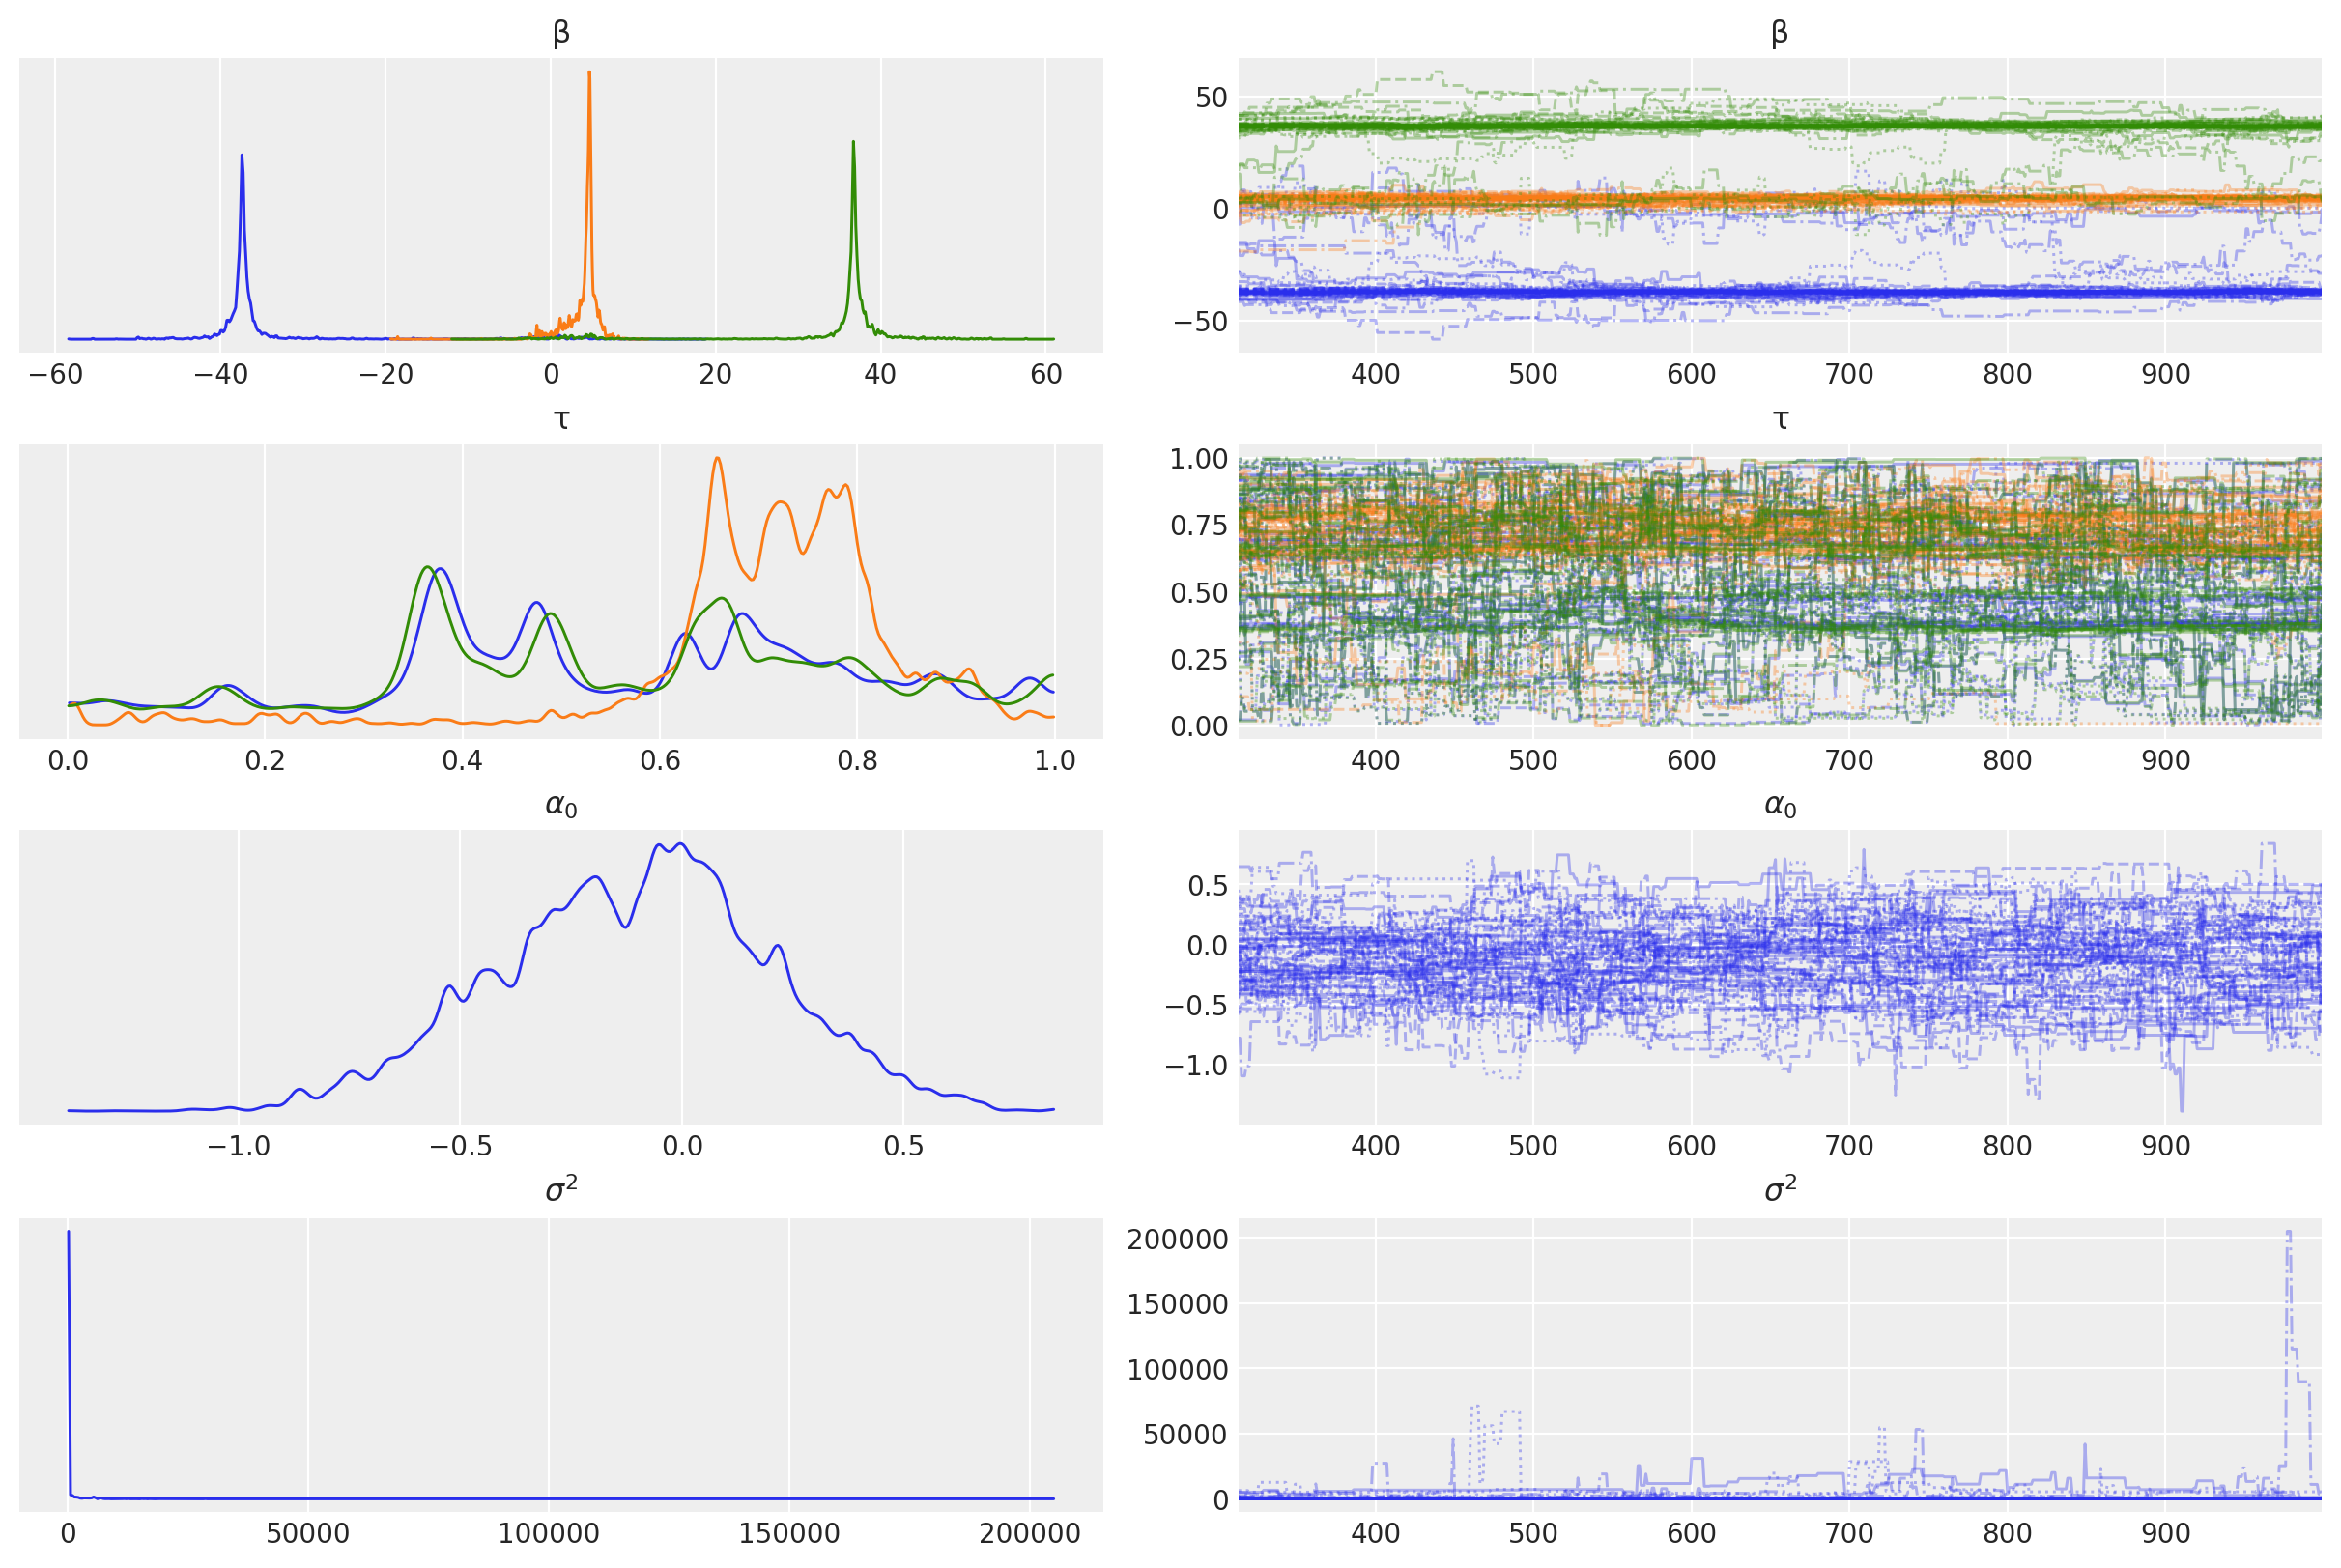

In [20]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
              combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


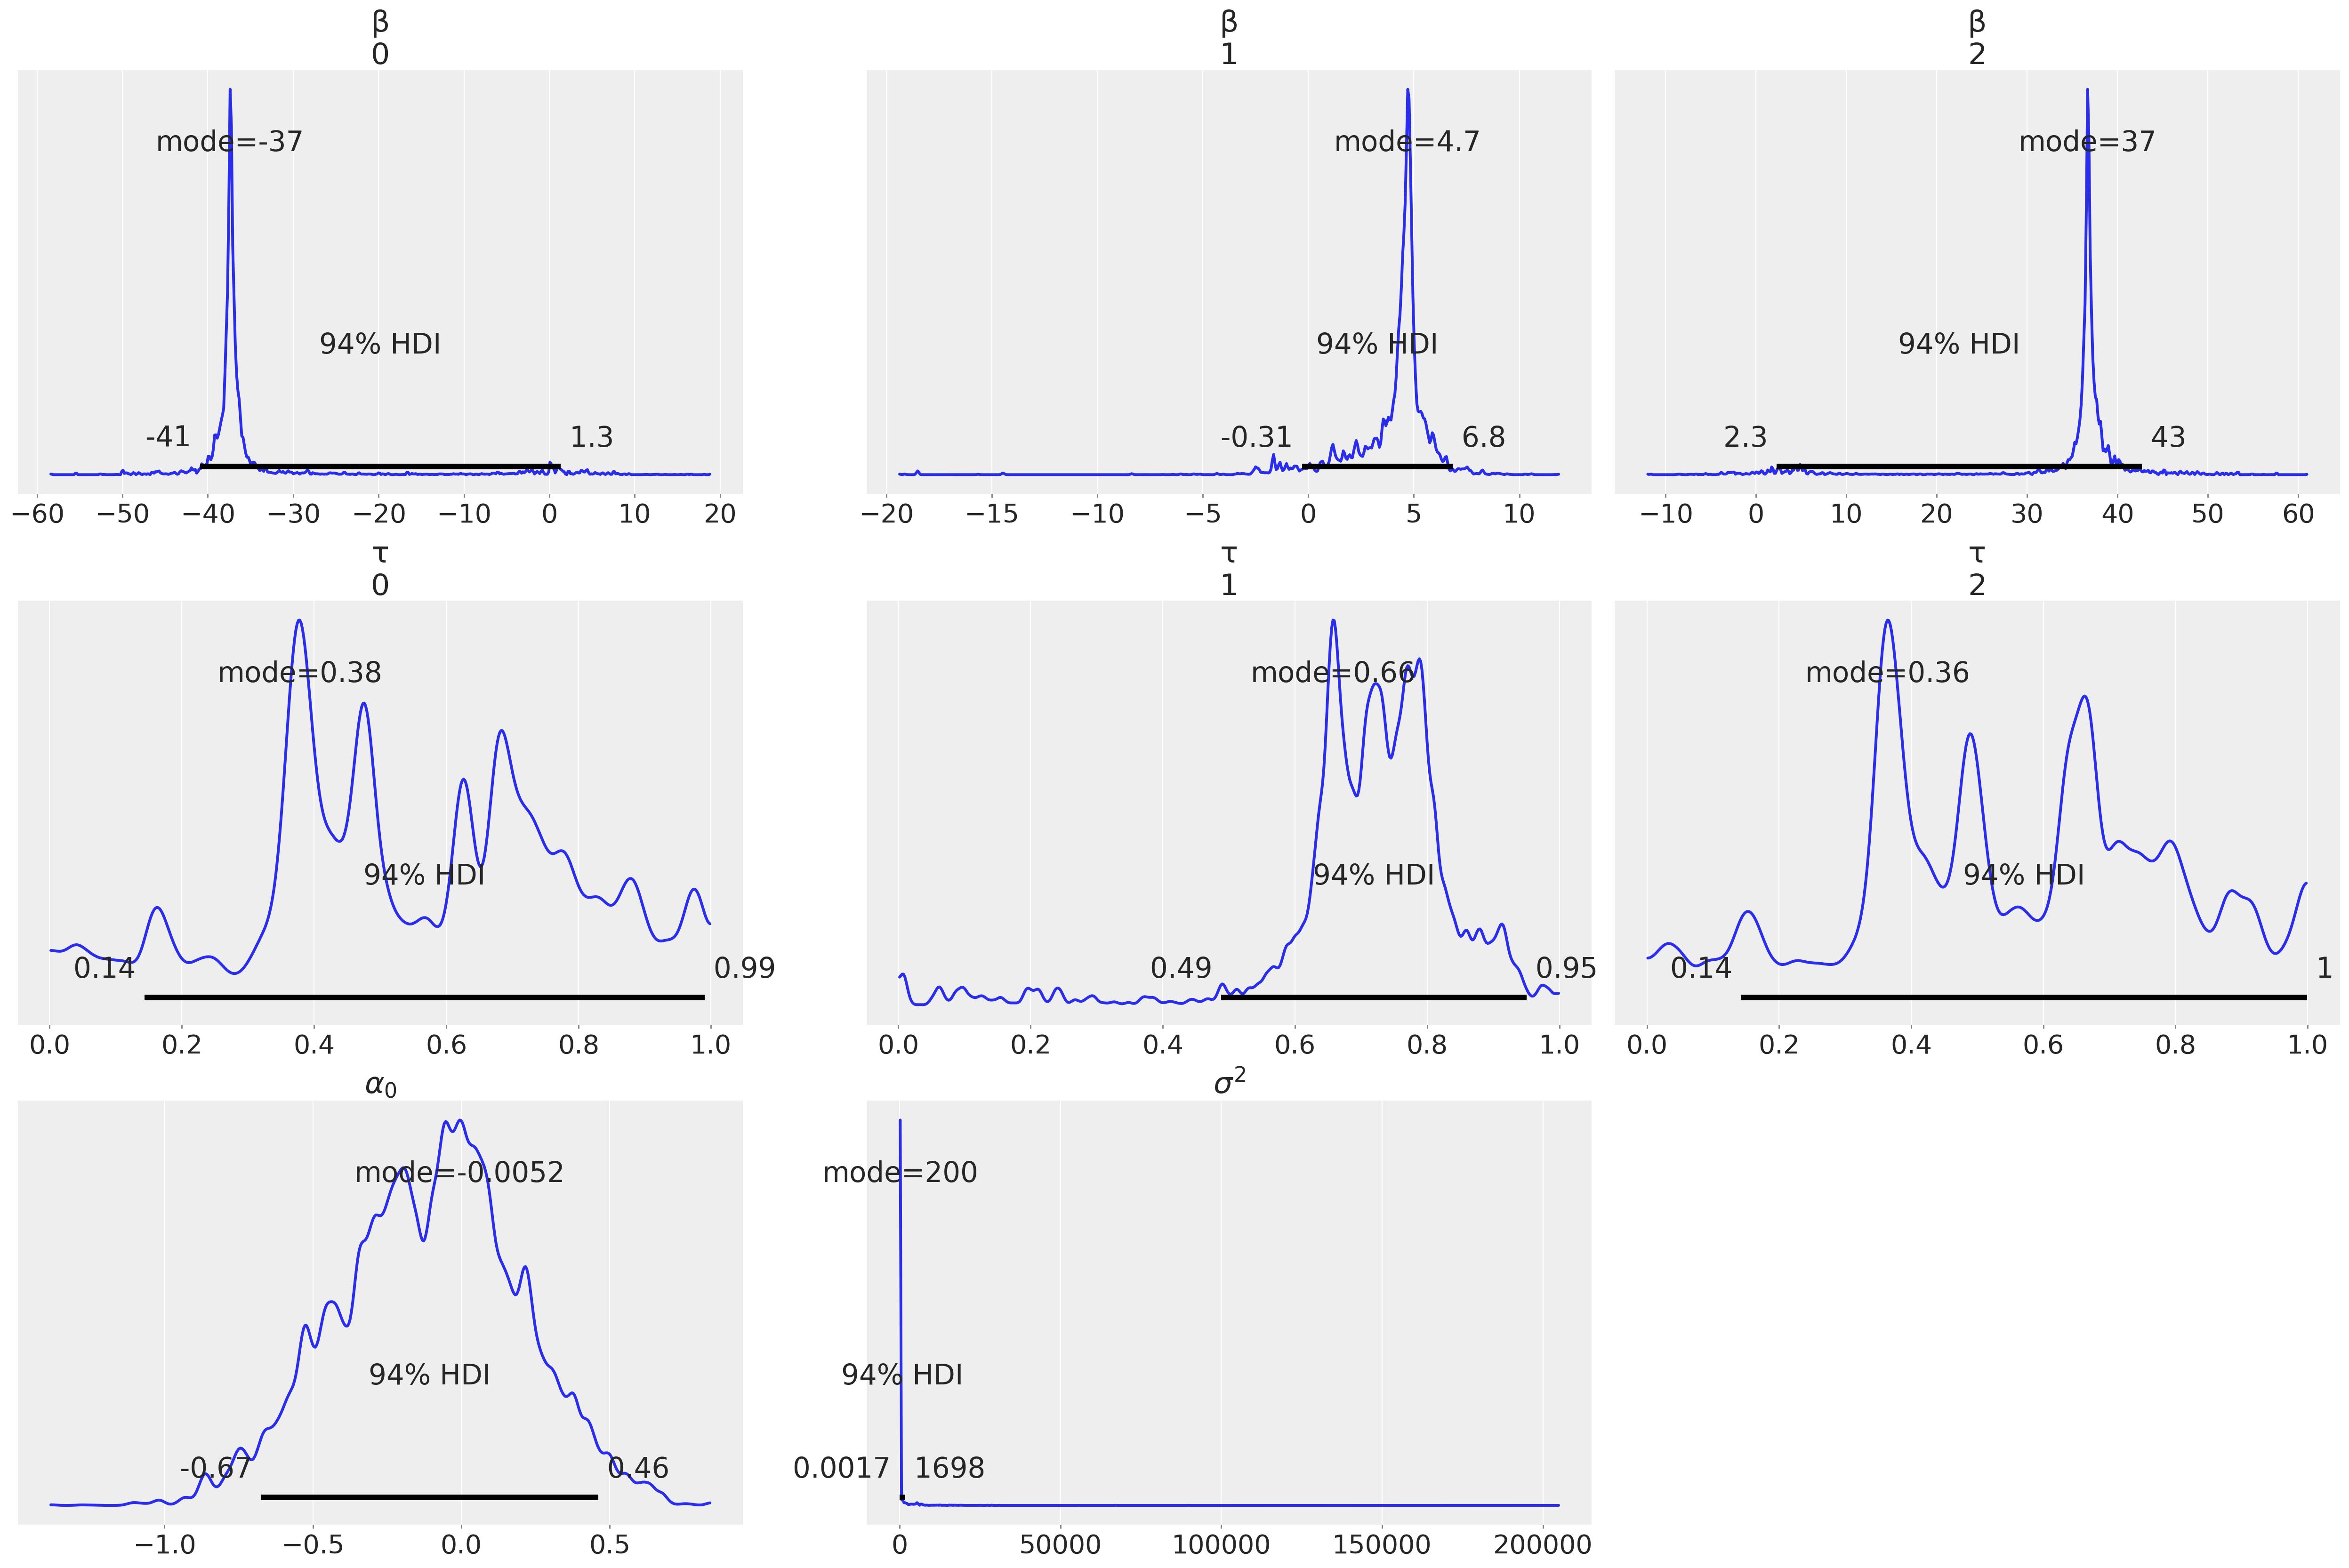

In [21]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

In this case, since the outcome variable is binary, we plot the distribution of $T(Y^*)$ to visually compare it with $T(Y)$, where $T$ is the number of $1$s in the sample (the number of successes). 

We also show a *separation plot*, in which the predicted probabilities $\hat p_i$ (suitably averaged for each chain and sample) are ordered in an ascending manner, and then a vertical line is drawn on each of them either in a dark color (if $y_i$ is 1) or a light color (if $y_i$ is 0). In a perfect model, all the dark lines would be on the rightmost part, effectively "separating" the samples.

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.531
bpv [T=mean]: 0.531
bpv [T=std]: 0.911


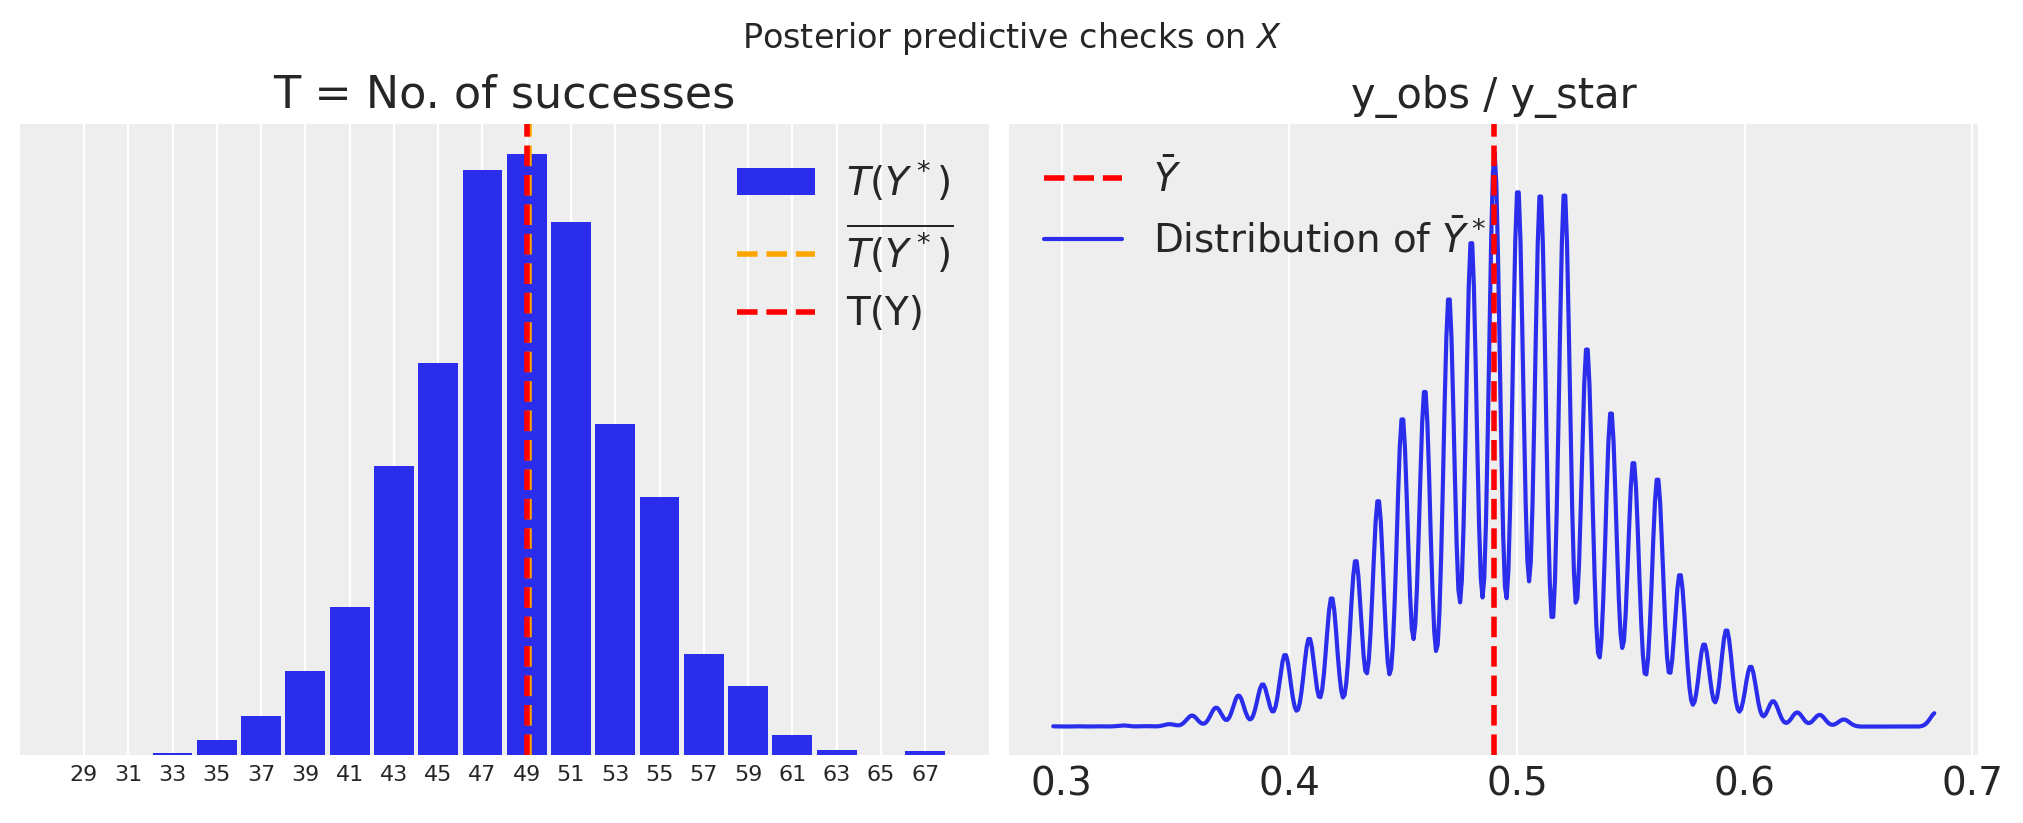

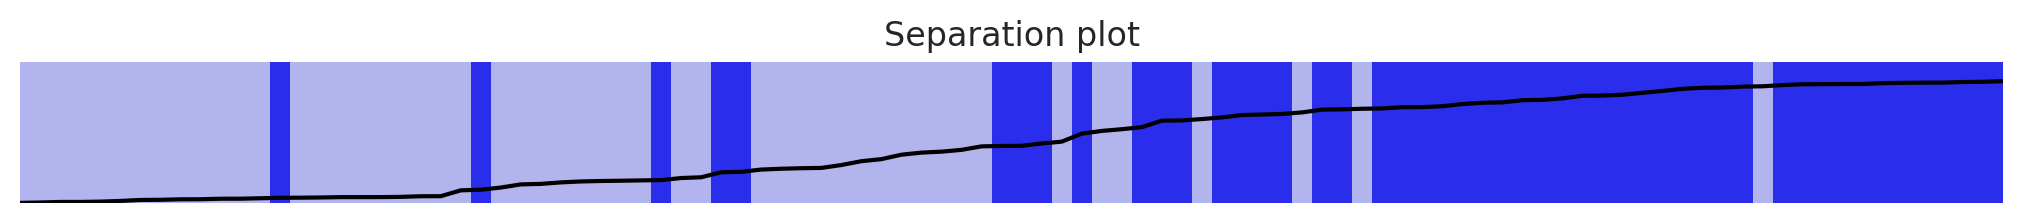

In [22]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp_p, pp_y = utils.generate_pp(
        idata_emcee, X, theta_names,
        rng=rng, kind='classification')
    utils.pp_to_idata([pp_p, pp_y], idata_emcee,
                      ["p_star", "y_star"], merge=True)
else:
    pp_p = idata_emcee.posterior_predictive['p_star'].to_numpy()
    pp_y = idata_emcee.posterior_predictive['y_star'].to_numpy().astype(int)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

n_success = pp_y.reshape(-1, len(Y)).sum(axis=1)
az.plot_dist(n_success, label=r"$T(Y^*)$", ax=axs[0])
axs[0].axvline(n_success.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y^*)}$")
axs[0].axvline(Y.sum(), ls="--", color="red",
               lw=2, label=r"T(Y)")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_emcee, kind='t_stat', t_stat='mean', data_pairs={
            'y_obs': 'y_star'}, plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_emcee, y="y_obs", y_hat="p_star", y_hat_line=True,
                   figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


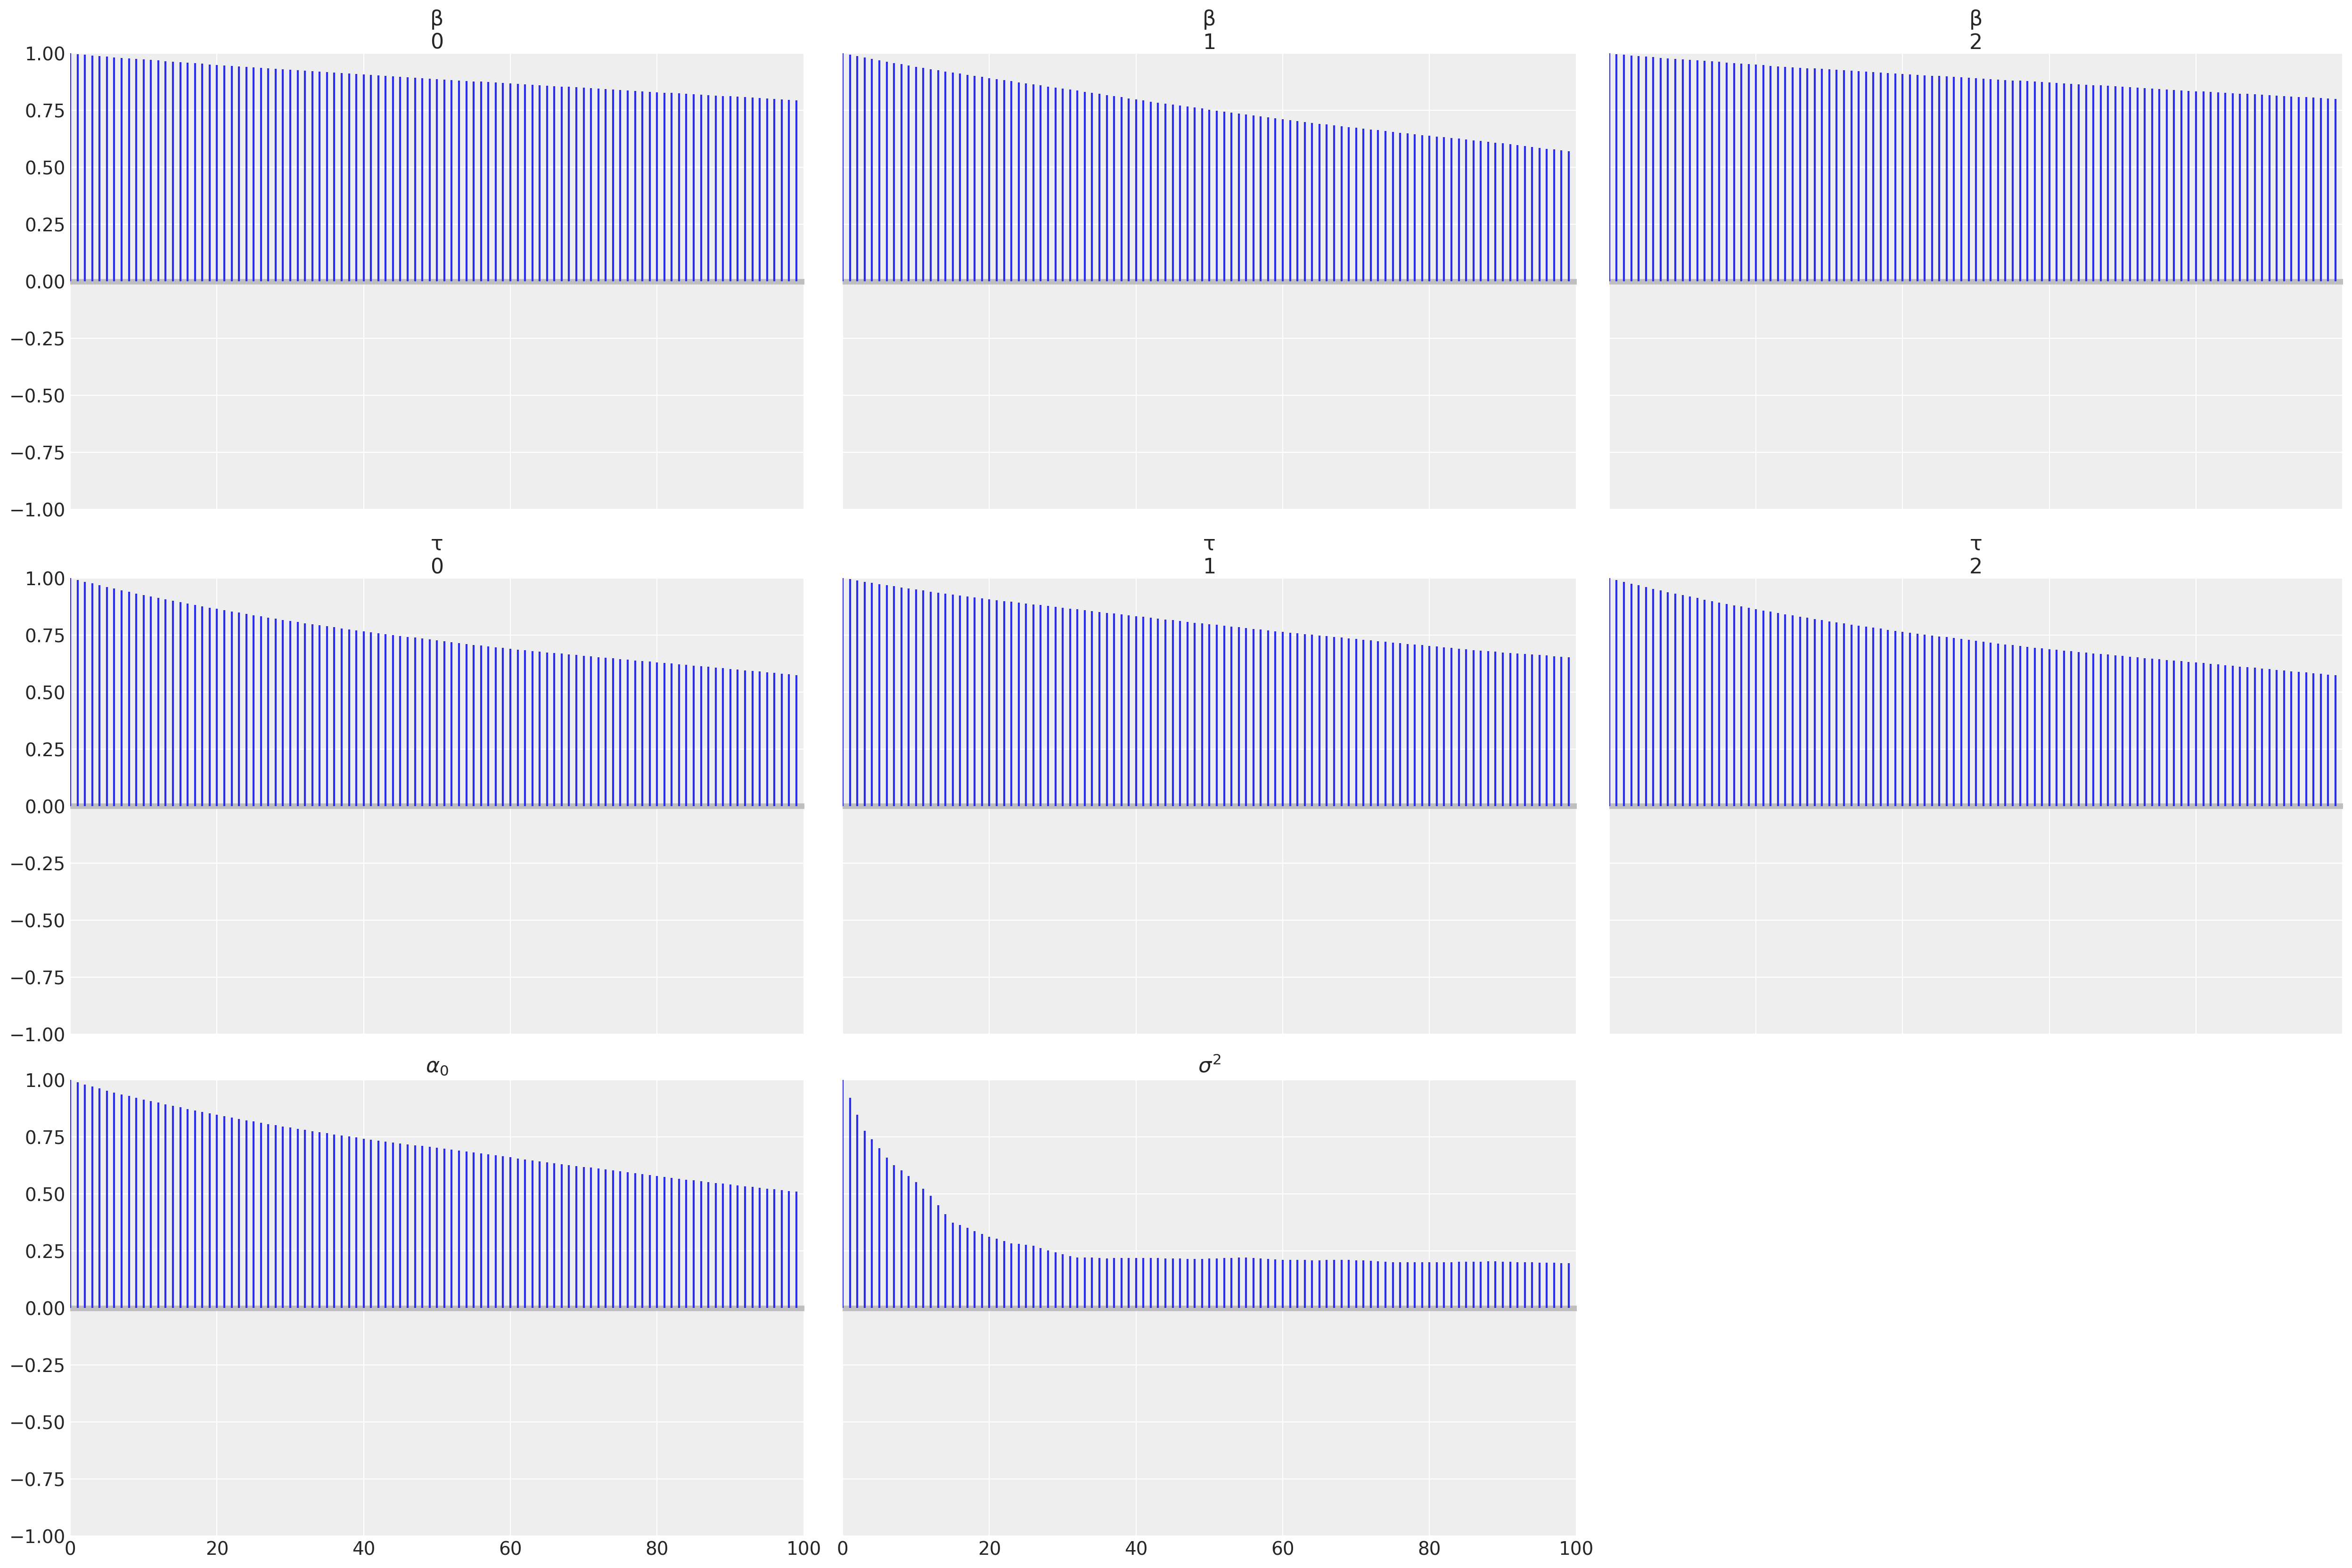

In [23]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.879
bpv [T=mean]: 0.879
bpv [T=std]: 0.930


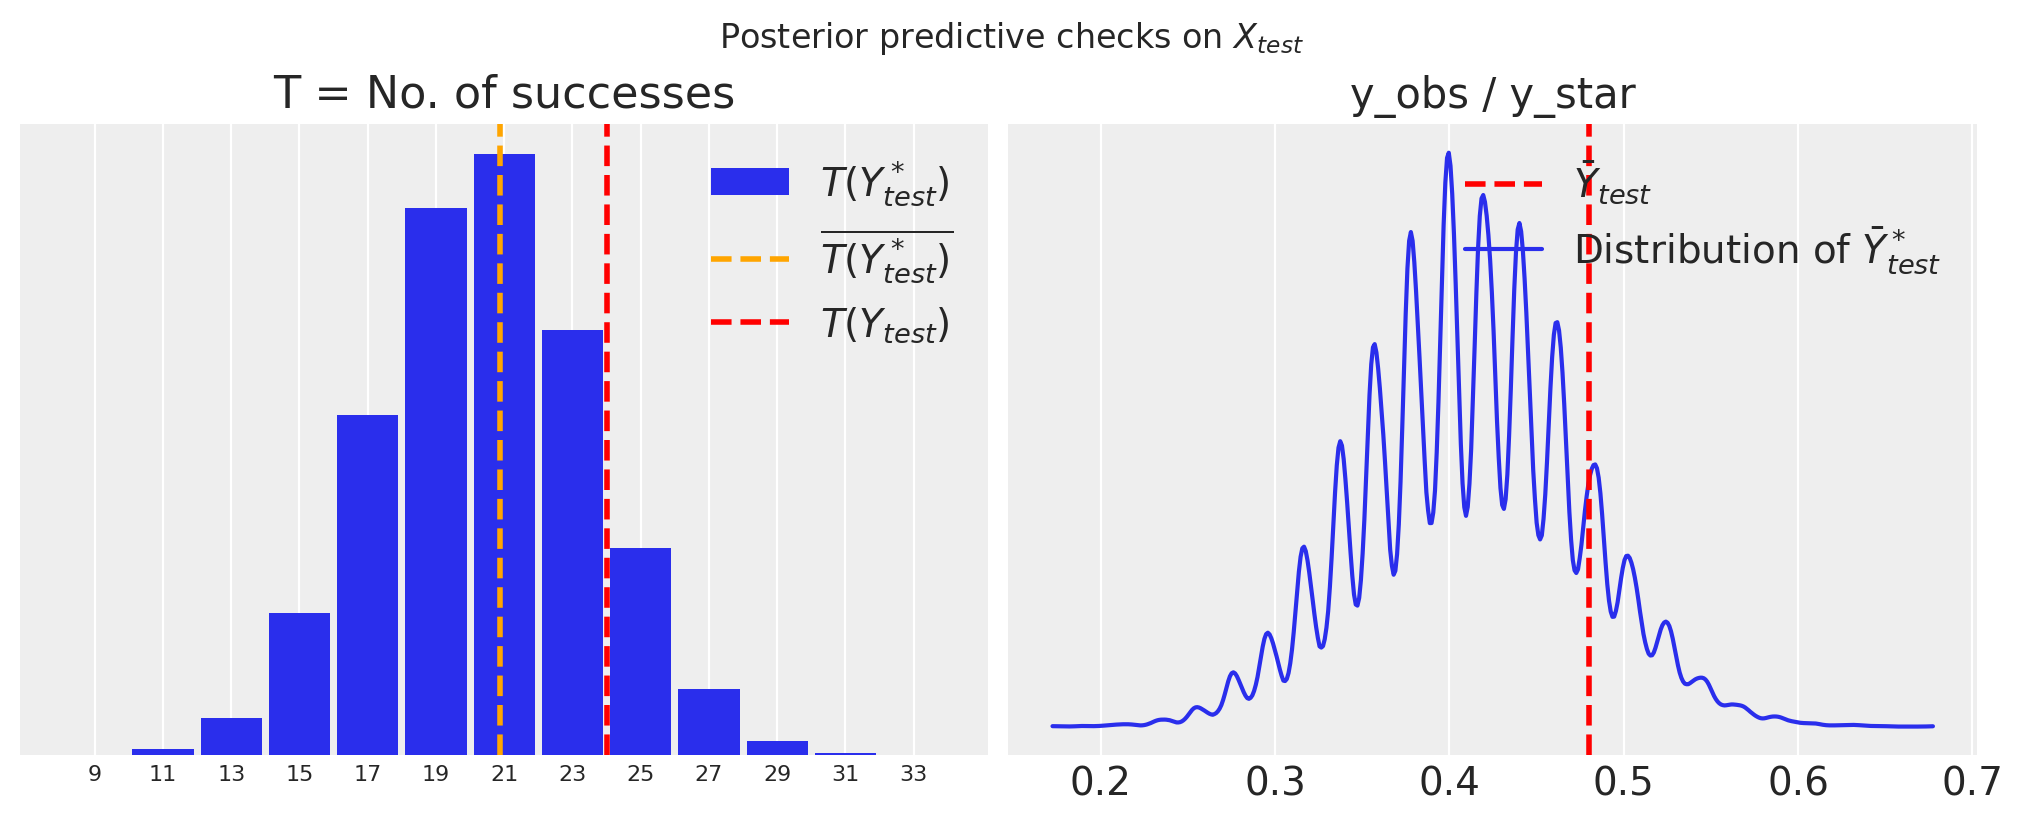

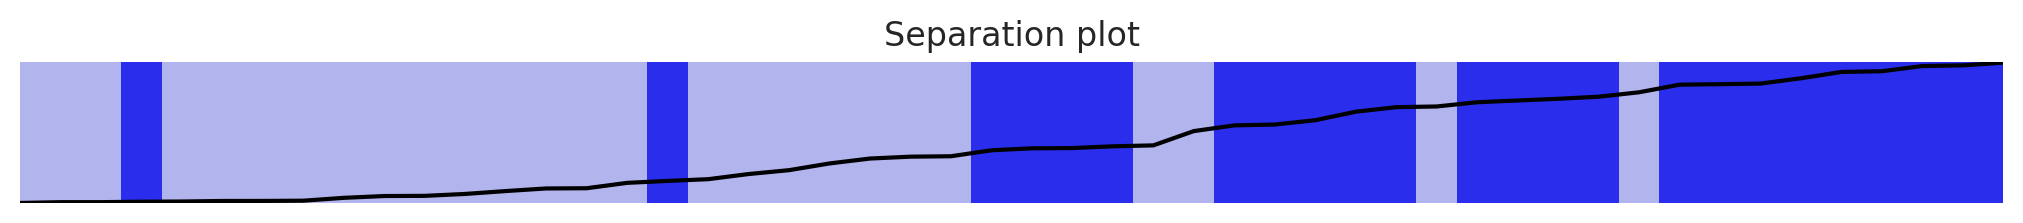

In [24]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = utils.generate_pp(
    idata_emcee, X_test, theta_names,
    rng=rng, kind='classification')
idata_pp_test = utils.pp_to_idata(
    [pp_test_p, pp_test_y], idata_emcee, ["p_star", "y_star"], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

n_success_test = pp_test_y.reshape(-1, len(Y_test)).sum(axis=1)
az.plot_dist(n_success_test, label=r"$T(Y_{test}^*)$", ax=axs[0])
axs[0].axvline(n_success_test.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y_{test}^*)}$")
axs[0].axvline(Y_test.sum(), ls="--", color="red",
               lw=2, label=r"$T(Y_{test})$")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean', data_pairs={
            'y_obs': 'y_star'}, plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y_test.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_pp_test, y="y_obs", y_hat="p_star", y_hat_line=True,
                   figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [25]:
# -- Compute metrics using several point estimates

df_metrics_emcee = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp_mean = [utils.threshold(y)
                 for y in pp_test_p[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_mean = utils.classification_metrics(Y_test, Y_hat_pp_mean)
Y_hat_pp_vote = [utils.threshold(y)
                 for y in pp_test_y[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_vote = utils.classification_metrics(Y_test, Y_hat_pp_vote)
df_metrics_emcee.loc[0] = [
    "emcee_posterior_mean",
    p_hat,
    metrics_pp_mean["acc"]
]
df_metrics_emcee.loc[1] = [
    "emcee_posterior_vote",
    p_hat,
    metrics_pp_vote["acc"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = utils.point_predict(
        X_test, idata_emcee,
        theta_names, pe, kind='classification')
    metrics_pe = utils.classification_metrics(Y_test, Y_hat_pe)
    df_metrics_emcee.loc[i + 2] = [
        "emcee_" + pe,
        p_hat,
        metrics_pe["acc"],
    ]

df_metrics_emcee.sort_values(
    results_columns[-1], inplace=True, ascending=False)
df_metrics_emcee.style.hide_index()

In [26]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_emcee, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="emcee",
        point_est=pe)

    df_metrics_emcee_var_sel = df_metrics_emcee_var_sel.append(df_var_sel)

df_metrics_emcee_var_sel.sort_values(
    results_columns[-1], inplace=True, ascending=False)
df_metrics_emcee_var_sel.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [27]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [28]:
# -- Probabilistic model

def make_model(theta_space, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = theta_space.grid
    p = theta_space.p

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        px = pm.Deterministic(
            'p_star',
            pm.math.invlogit(alpha0 + pm.math.matrix_dot(X_tau, beta)))

        y_obs = pm.Bernoulli('y_obs', p=px, observed=Y)

    return model

### Experiments

In [29]:
# -- Hyperparameters

burn = 0
thin = 1
thin_pp = 5

n_samples_nuts = 1000
tune_nuts = 1200
target_accept = 0.81
n_samples_metropolis = 10000
tune_metropolis = 3000

USE_NUTS = False

In [30]:
# -- Run sampler

model = make_model(theta_space, g, eta, X, Y, theta_names,
                   theta_names_aux[:1], mle_theta_tr)

with model:
    if USE_NUTS:
        idata_pymc = pm.sample(n_samples_nuts, cores=2,
                               tune=tune_nuts, target_accept=0.81,
                               return_inferencedata=True)
    else:
        step = pm.Metropolis()
        idata_pymc = pm.sample(n_samples_metropolis, cores=2,
                               tune=tune_metropolis, step=step,
                               return_inferencedata=True)

    idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0 and log σ]


Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [31]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]       -37.465   1.085 -39.197  -35.581      0.106    0.076     164.0   
β[1]         4.647   1.095   2.921    5.665      0.126    0.091     148.0   
β[2]        36.820   0.836  35.734   38.875      0.051    0.037     154.0   
τ[0]         0.596   0.176   0.340    0.862      0.093    0.072       4.0   
τ[1]         0.759   0.078   0.638    0.920      0.016    0.011      26.0   
τ[2]         0.594   0.177   0.330    0.859      0.094    0.073       4.0   
$\alpha_0$  -0.120   0.308  -0.677    0.481      0.006    0.004    2496.0   
$\sigma^2$   7.422  52.885   0.000   19.060      3.361    2.380      11.0   

            ess_tail  r_hat    mode  median  
β[0]            90.0   1.12 -37.378 -37.377  
β[1]           120.0   1.05   4.724   4.712  
β[2]           165.0   1.07  36.703  36.696  
τ[0]            29.0   1.46   0.742   0.666  
τ[1]            47.0   1.12   0.798   0.760  
τ[2]            31.0   1.46   0.364   0.657  
$\alpha_0$    4108.0   1.00  -0.192  -0.123  
$\sigma^2$      60.0   1.15   1.988   0.214

Density and trace plot:


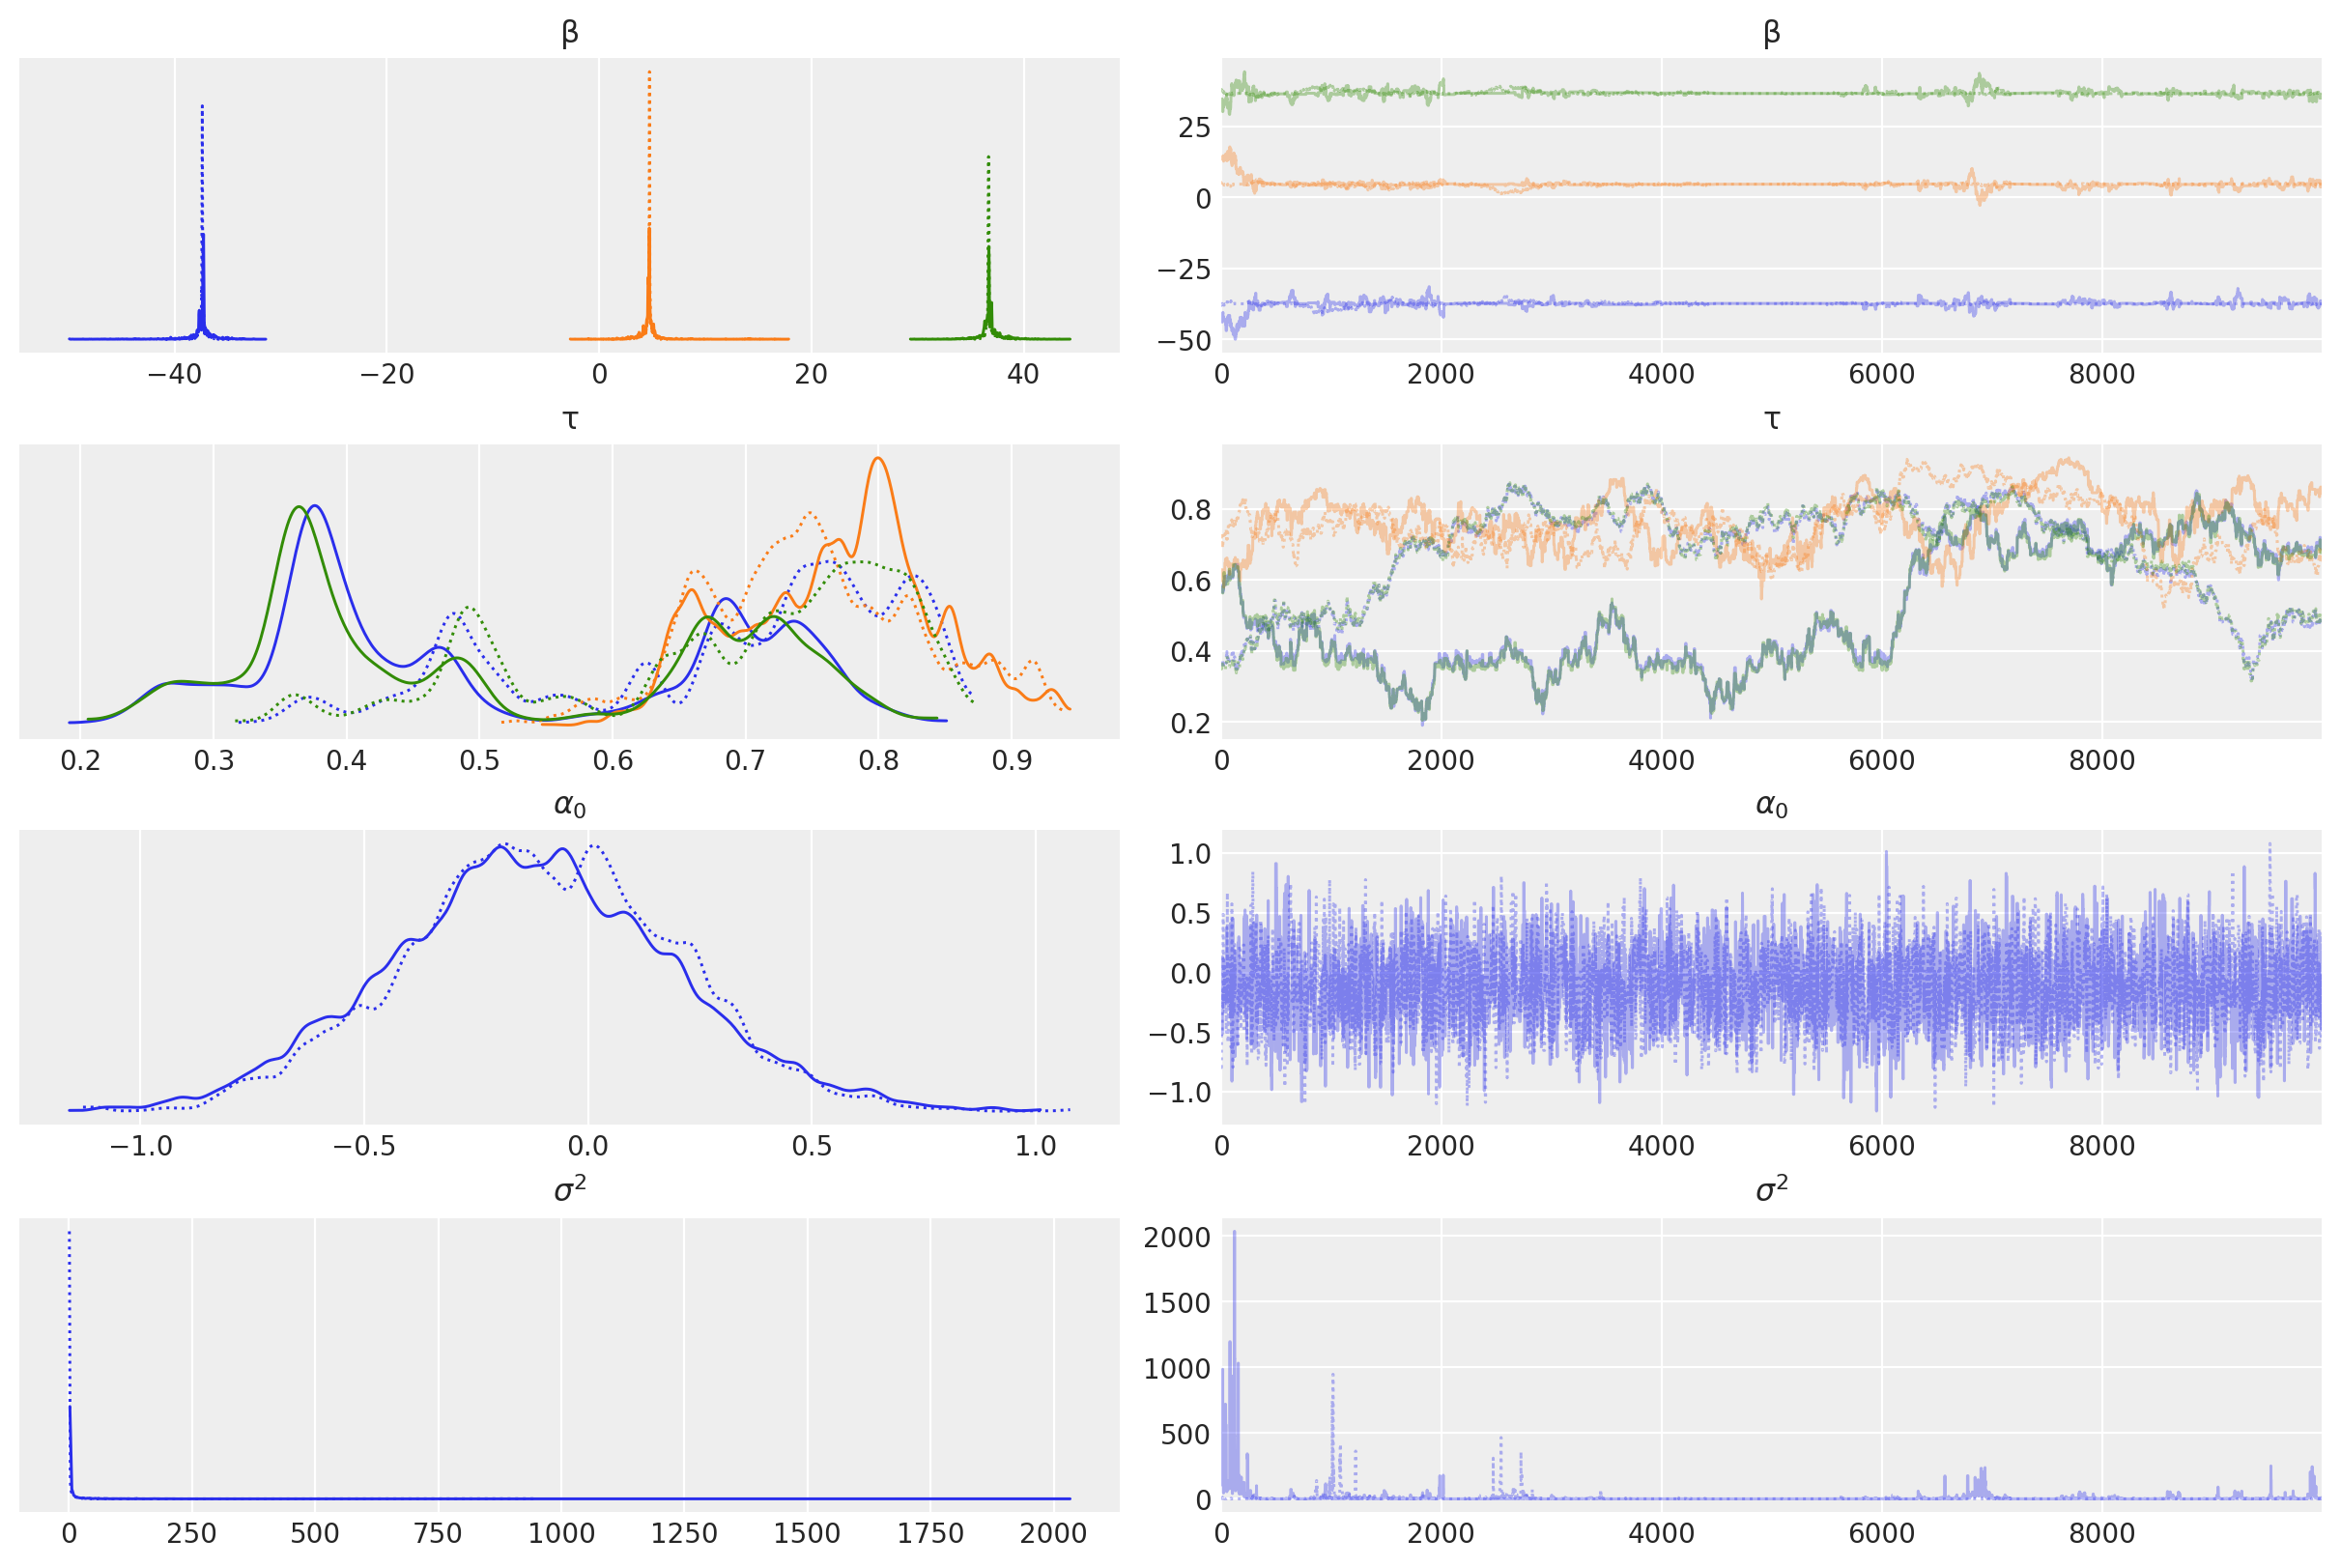

In [32]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


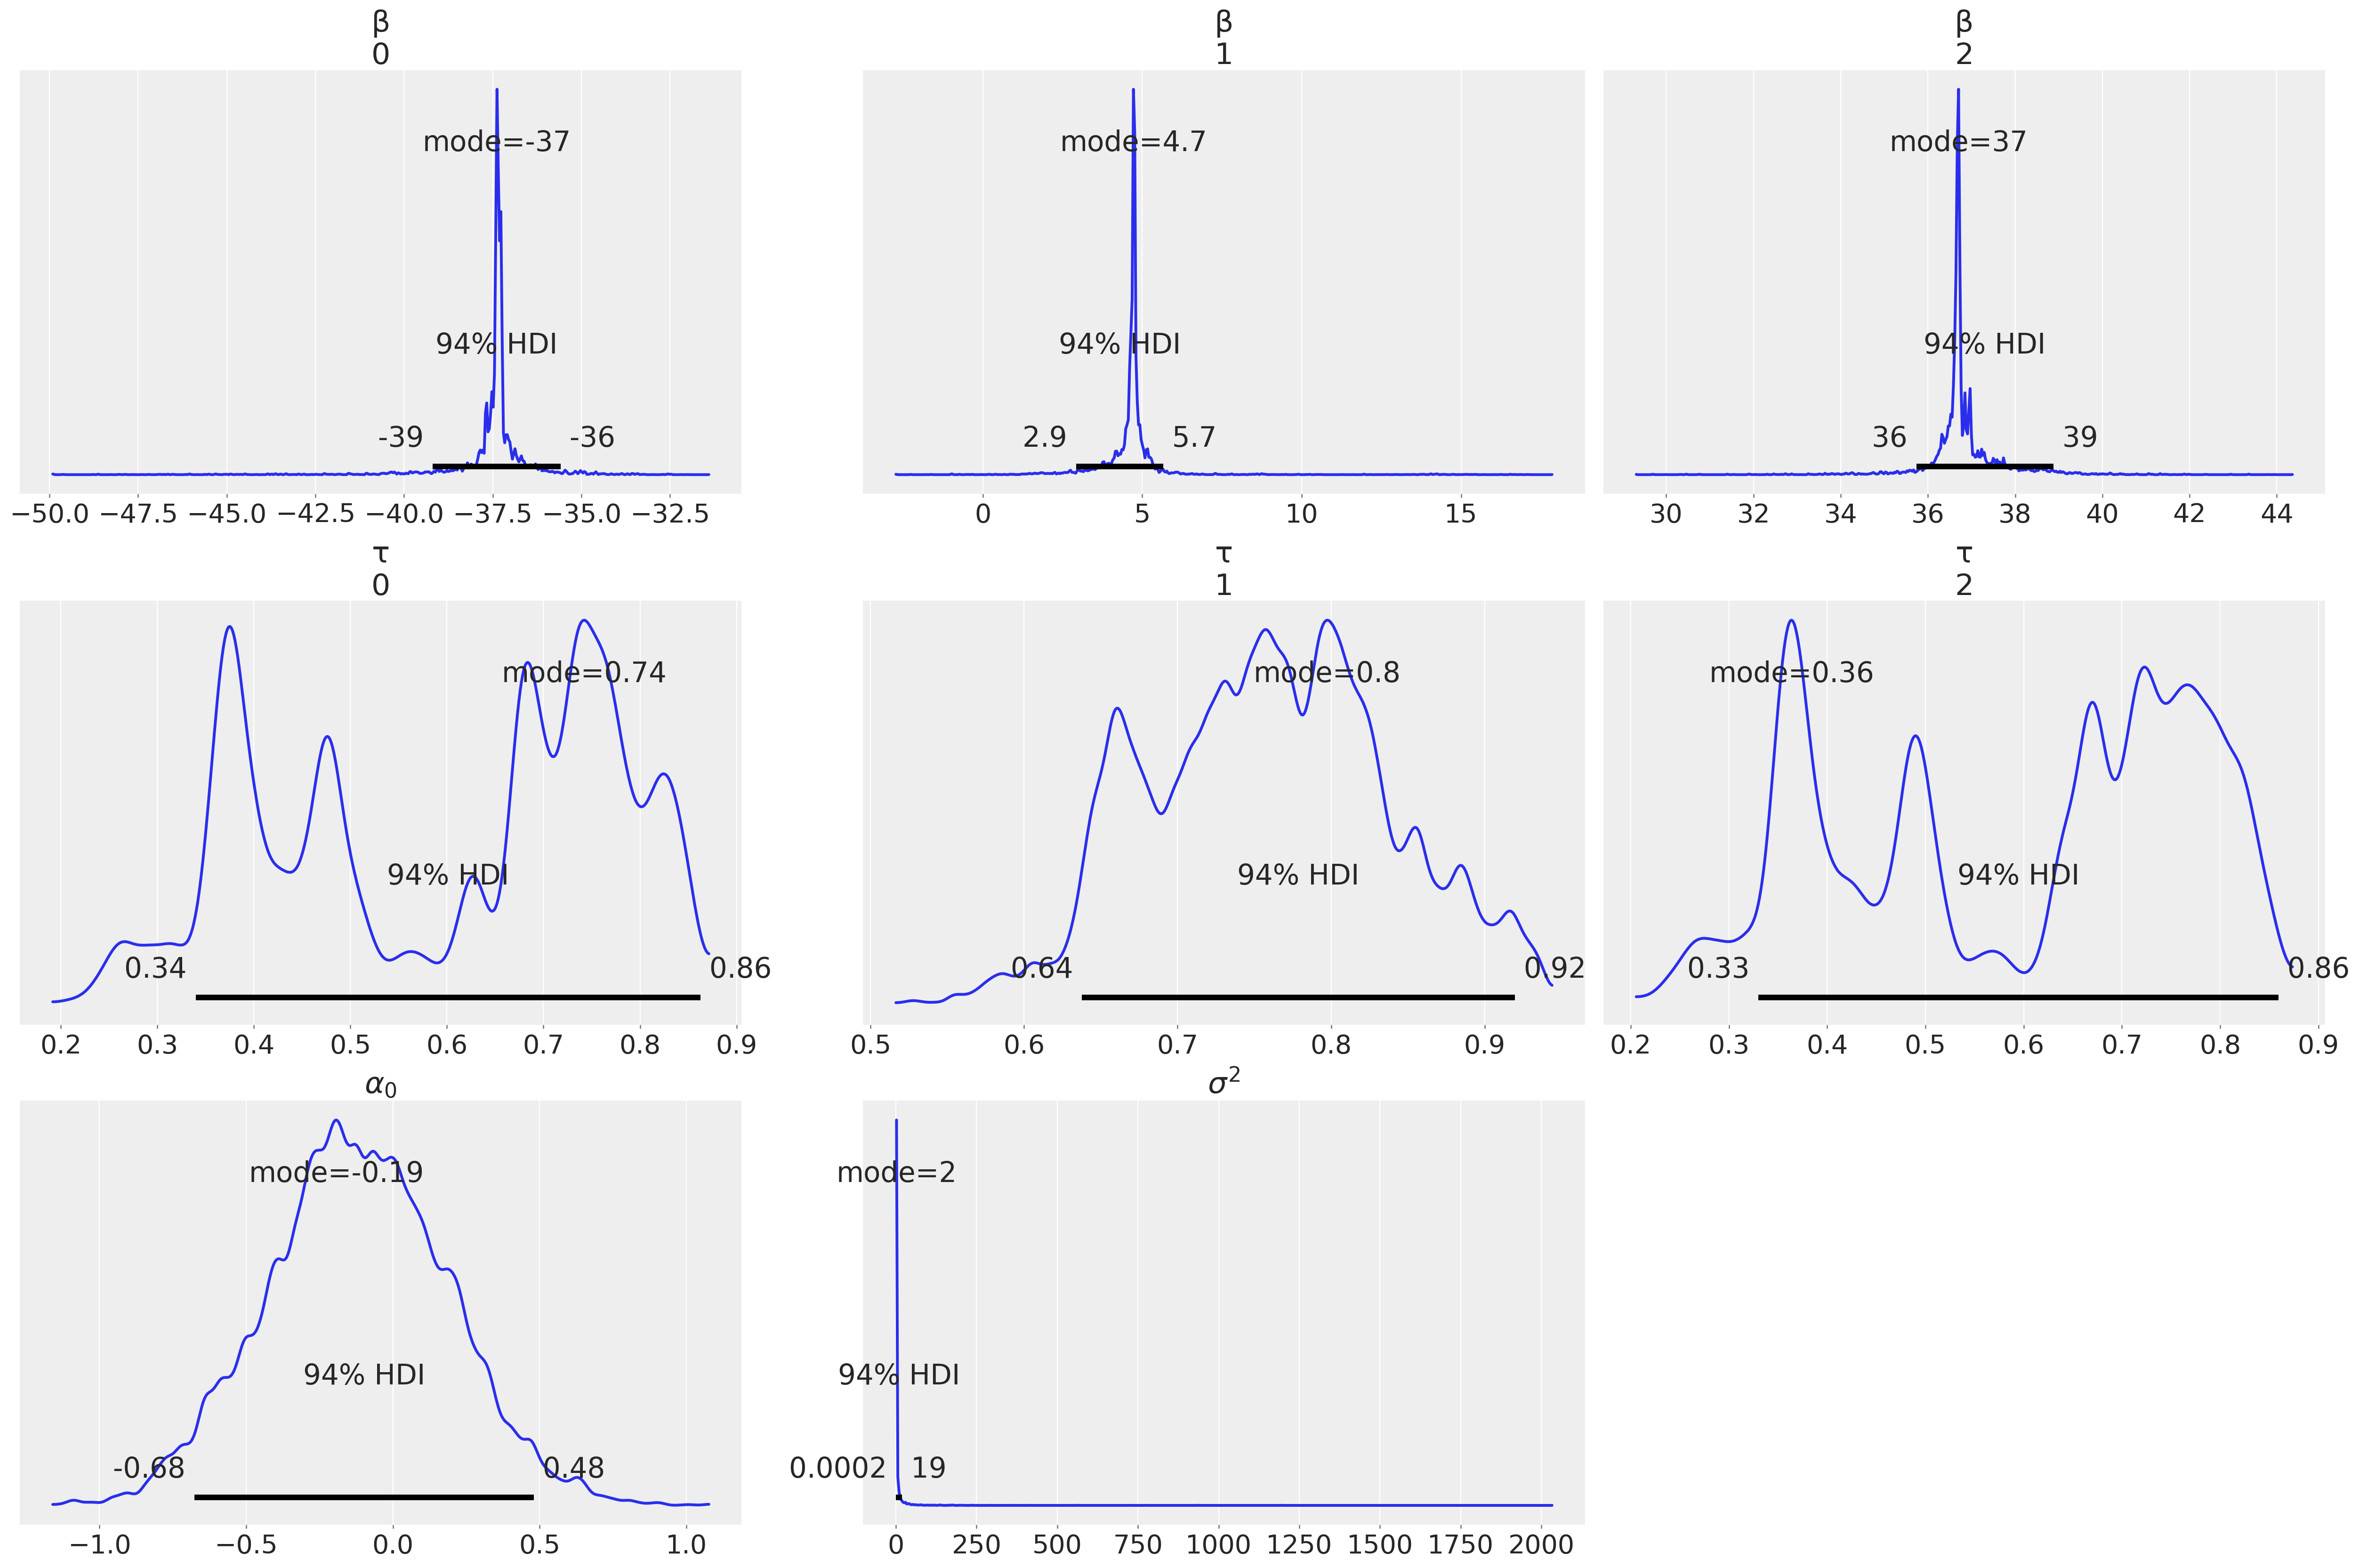

In [33]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.541
bpv [T=mean]: 0.541
bpv [T=std]: 0.916


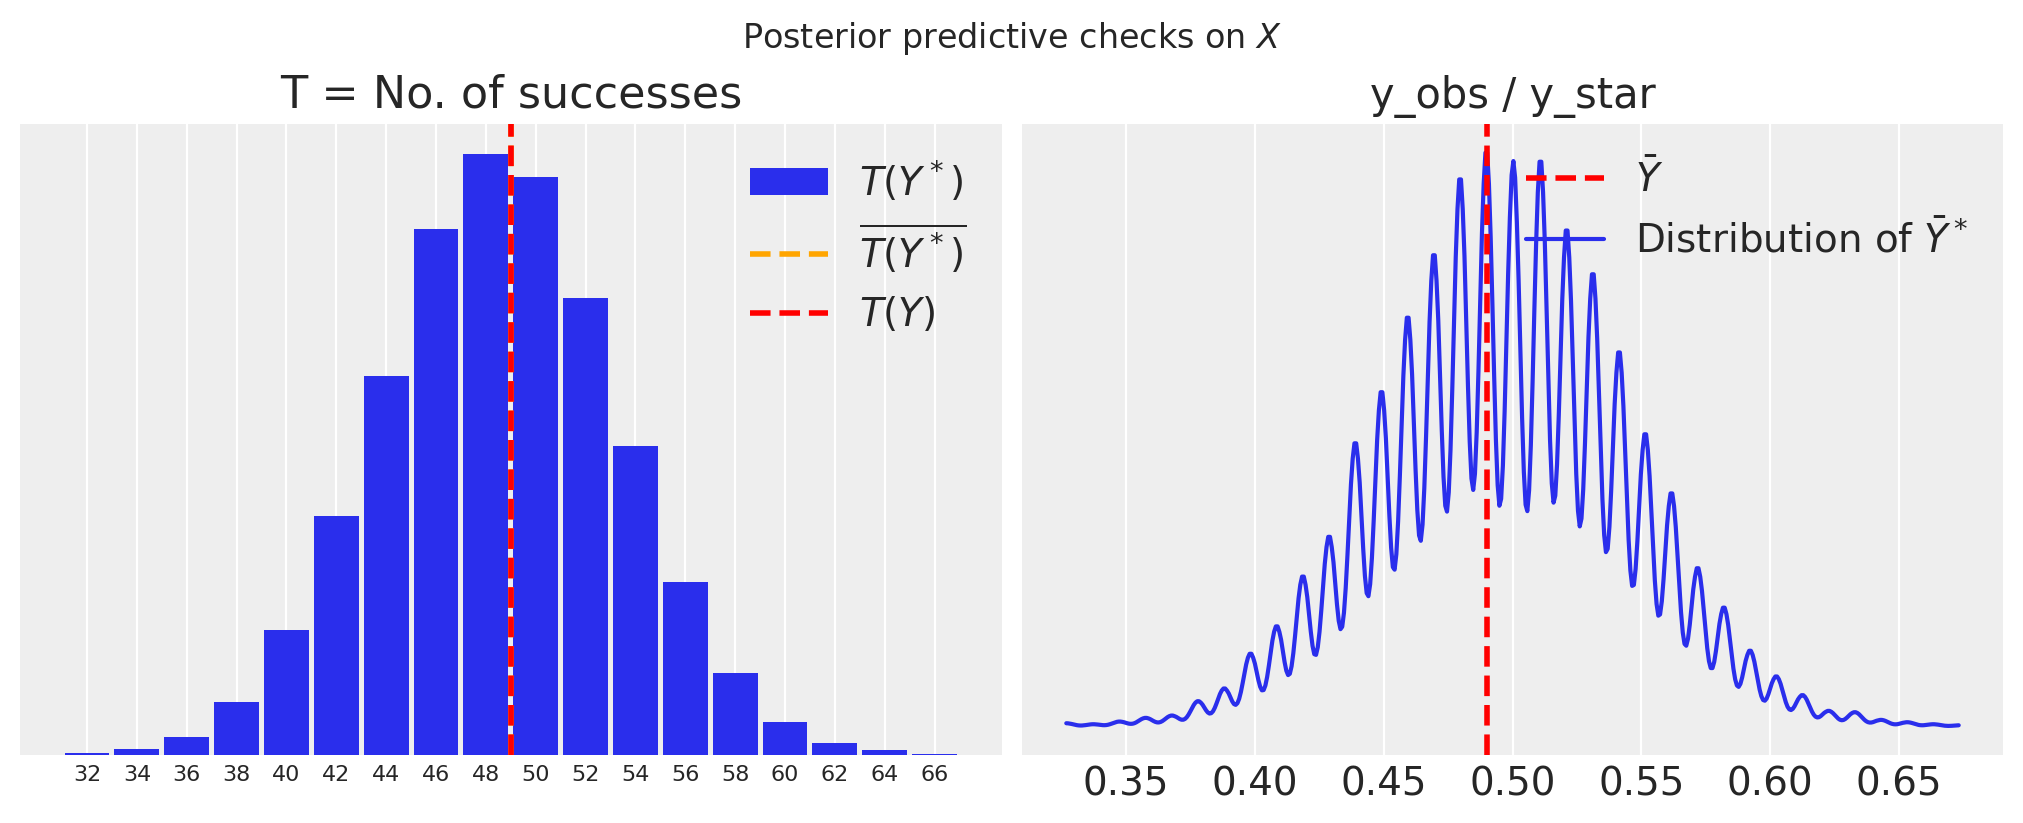

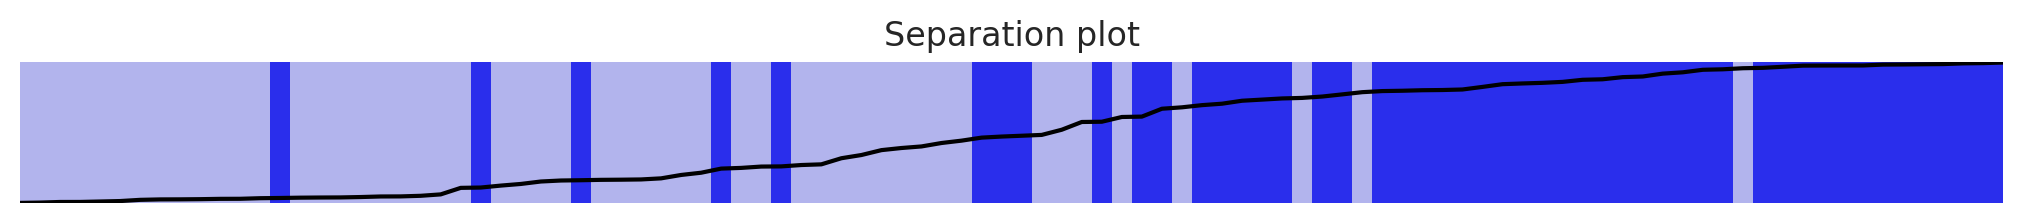

In [34]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    pp_p, pp_y = utils.generate_pp(
        idata_pymc, X, theta_names, rng=rng, kind='classification')
    utils.pp_to_idata([pp_p, pp_y], idata_pymc,
                      ['p_star', 'y_star'], merge=True)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

n_success = pp_y.reshape(-1, len(Y)).sum(axis=1)
az.plot_dist(n_success, label=r"$T(Y^*)$", ax=axs[0])
axs[0].axvline(n_success.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y^*)}$")
axs[0].axvline(Y.sum(), ls="--", color="red",
               lw=2, label=r"$T(Y)$")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_pymc, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False,
            data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_pymc, y="y_obs", y_hat="p_star", y_hat_line=True,
                   figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


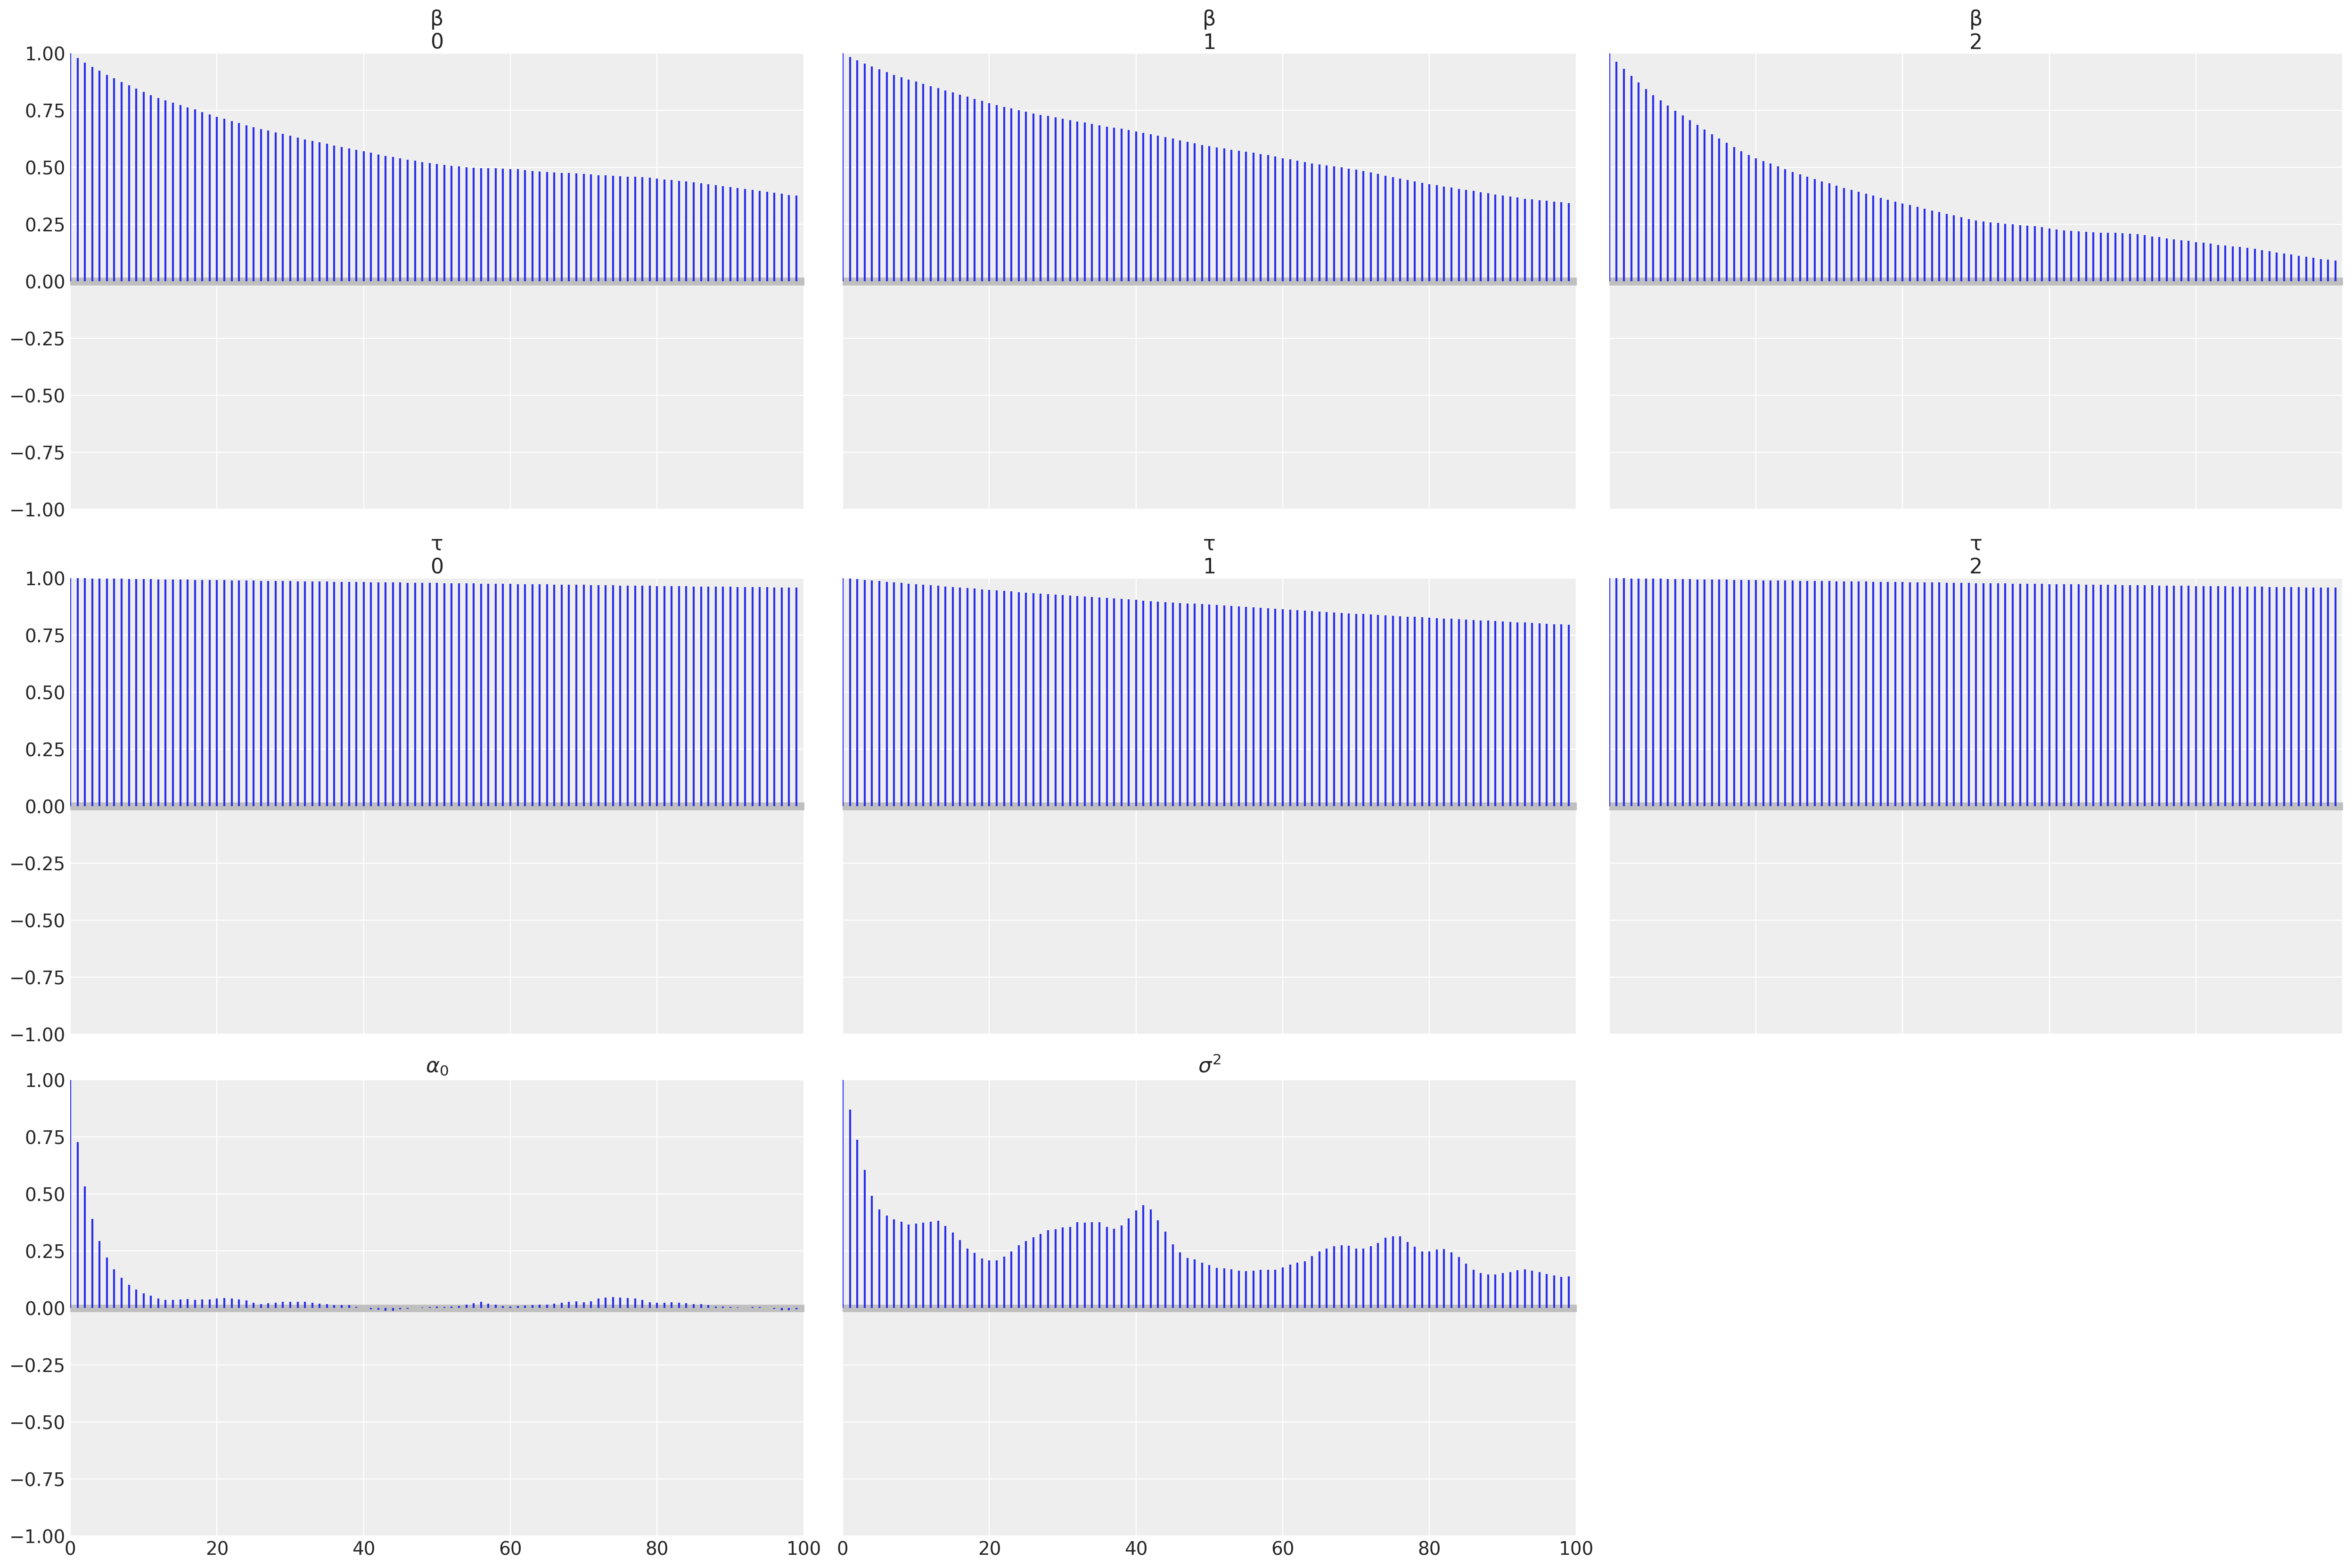

In [35]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

Graphical model:


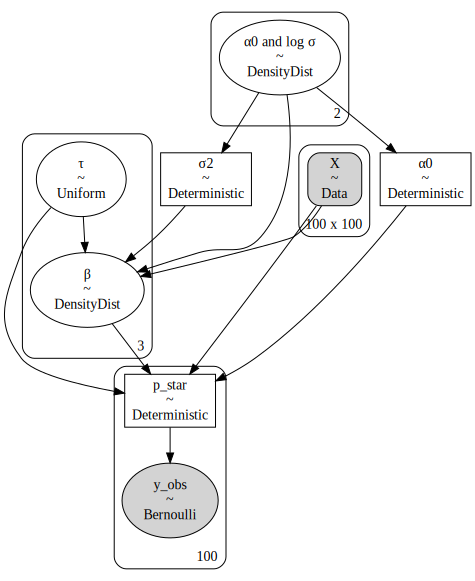

In [39]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


Posterior predictive samples:   0%|          | 0/2 [00:00<?, ?it/s]

bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.870
bpv [T=mean]: 0.870
bpv [T=std]: 0.929


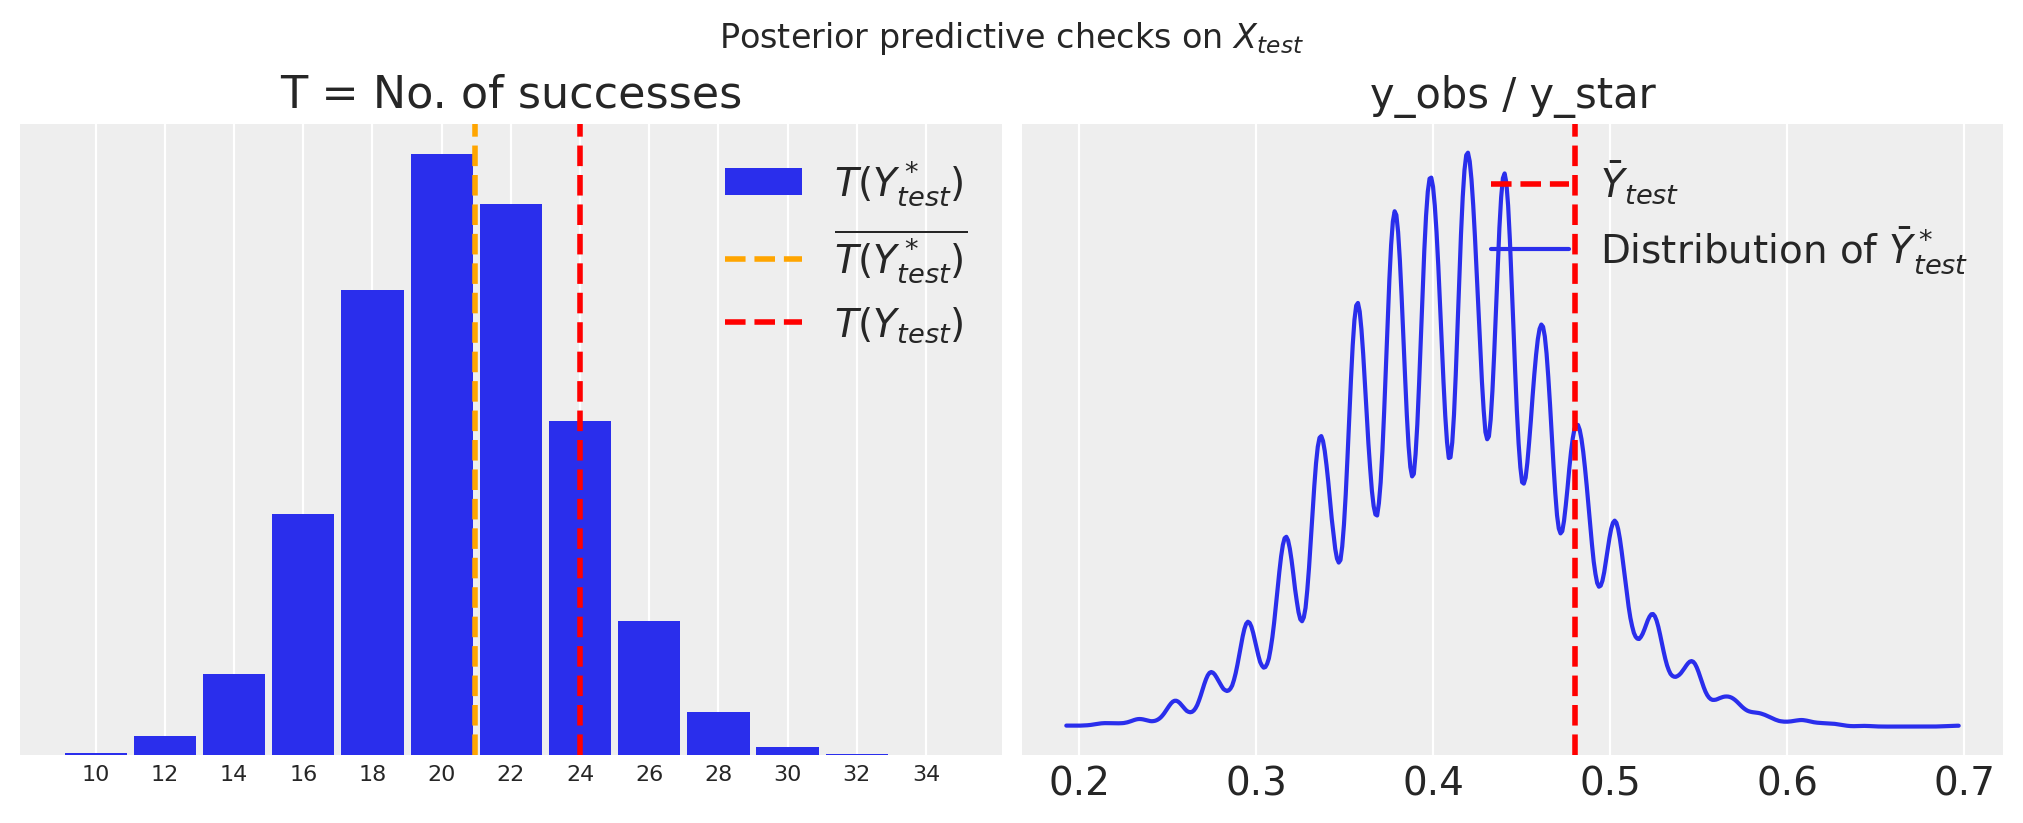

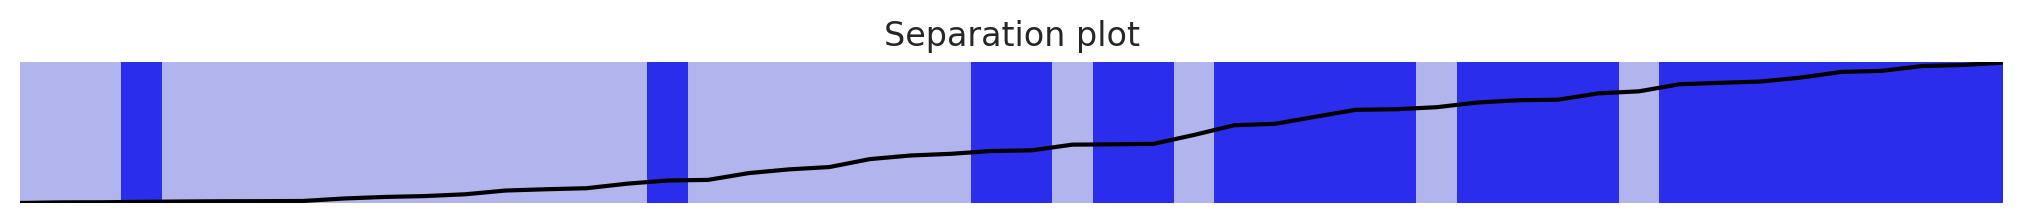

In [36]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(theta_space, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    pp_test_p, pp_test_y = utils.generate_pp(
        idata_pymc, X_test, theta_names, rng=rng, kind='classification')
    idata_pp_test = utils.pp_to_idata(
        [pp_test_p, pp_test_y], idata_pymc,
        ['p_star', 'y_star'], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

n_success_test = pp_test_y.reshape(-1, len(Y_test)).sum(axis=1)
az.plot_dist(n_success_test, label=r"$T(Y_{test}^*)$", ax=axs[0])
axs[0].axvline(n_success_test.mean(), ls="--", color="orange",
               lw=2, label=r"$\overline{T(Y_{test}^*)}$")
axs[0].axvline(Y_test.sum(), ls="--", color="red",
               lw=2, label=r"$T(Y_{test})$")
axs[0].set_title("T = No. of successes")
axs[0].legend()
axs[0].set_yticks([])
axs[0].tick_params(labelsize=8)

az.plot_bpv(idata_pp_test, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False,
            data_pairs={"y_obs": "y_star"})
axs[1].axvline(Y_test.mean(), ls="--", color="r",
               lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
axs[1].legend(handles=handles)

# Separation plot
az.plot_separation(idata_pp_test, y="y_obs", y_hat="p_star",
                   y_hat_line=True, figsize=(10, 1), legend=False)
plt.title("Separation plot", fontsize=12)

# Show Bayesian p-values
for name, stat in statistics:
    bpv = utils.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters.

In [37]:
# -- Compute metrics using several point estimates

df_metrics_pymc = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat_pp_mean = [utils.threshold(y)
                 for y in pp_test_p[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_mean = utils.classification_metrics(Y_test, Y_hat_pp_mean)
Y_hat_pp_vote = [utils.threshold(y)
                 for y in pp_test_y[:, ::thin_pp, :].mean(axis=(0, 1))]
metrics_pp_vote = utils.classification_metrics(Y_test, Y_hat_pp_vote)
df_metrics_pymc.loc[0] = [
    "pymc_posterior_mean",
    p_hat,
    metrics_pp_mean["acc"]
]
df_metrics_pymc.loc[1] = [
    "pymc_posterior_vote",
    p_hat,
    metrics_pp_vote["acc"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat_pe = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe, kind='classification')
    metrics_pe = utils.classification_metrics(Y_test, Y_hat_pe)
    df_metrics_pymc.loc[i + 2] = [
        "pymc_" + pe,
        p_hat,
        metrics_pe["acc"],
    ]

df_metrics_pymc.sort_values(results_columns[-1], inplace=True, ascending=False)
df_metrics_pymc.style.hide_index()

In [38]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = pd.DataFrame(columns=results_columns)

for pe in point_estimates:
    df_var_sel = bayesian_var_sel(
        idata_pymc, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="pymc",
        point_est=pe)

    df_metrics_pymc_var_sel = df_metrics_pymc_var_sel.append(df_var_sel)

df_metrics_pymc_var_sel.sort_values(
    results_columns[-1], inplace=True, ascending=False)
df_metrics_pymc_var_sel.style.hide_index()

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Dec 22 2021

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.30.1

skfda     : 0.0
matplotlib: 3.5.1
pandas    : 1.3.5
scipy     : 1.7.3
emcee     : 3.1.1
logging   : 0.5.1.2
json      : 2.0.9
numpy     : 1.20.3
autopep8  : 1.6.0
arviz     : 0.11.4
sys       : 3.9.9 (main, Dec 22 2021, 14:49:36) 
[GCC 11.1.0]
pymc3     : 3.11.4
theano    : 1.1.2

Watermark: 2.2.0

